In [186]:
library('igraph')
library('Matrix')
library('pracma')
library('visNetwork')

In [187]:
g<-read_graph('facebook_combined.txt', directed=F)
V(g)$vid <- seq(1, vcount(g))

In [188]:
create_personalized_network = function (n, g, add_core=T){
    m = seq(1,vcount(g))
    included = m %in% neighbors(g,n)
    if (add_core)
        included = included | (m == n)
    m = m[!included]
    
    p_network = delete.vertices(g, m)
    
    return(p_network)
}

In [230]:
get_embeddedness = function (n, g, pdf=F, b=100) {
    g1 <- create_personalized_network(n, g, F)
    embed <- degree(g1)
    if (!pdf)
        return (embed)
    h<-hist(embed, breaks=b, plot=F)
    h$counts=h$counts/sum(h$counts)
    return(h)
}

In [231]:
# Helper function. 
dispersion_distance = function(g, diameter) {
    sp <- shortest.paths(g, mode="all")
    sp_rem_infs <- do.call('c', lapply(sp, function(x) if(is.infinite(x)) x=(diameter+1) else x))
        
    disper <- sum(sp_rem_infs)/2
    return(disper)
}

In [232]:
get_dispersion = function(n, g, pdf=F, b=100) {
    # create the personalized network for the core node. 
    g1 = create_personalized_network(n, g, F)
    # create a smaller personalized network for each node in the personalized network - representing mutual friends. 
    small_nets <- lapply(V(g1), create_personalized_network, g1, F) 
    
    #lapply(small_nets, plot, vertex.size=2,vertex.label.cex=0.1)
    #lapply(small_nets, shortest.paths, mode="all")
    dispersion <- do.call('c', lapply(small_nets, dispersion_distance, diameter(g)))
    if (!pdf)
        return(dispersion)
    h<-hist(dispersion, breaks=b, plot=F)
    h$counts=h$counts/sum(h$counts)
    return(h)               
}

[1] TRUE

[1] 4039

[1] 8

[1] 43.69101

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"819 y values <= 0 omitted from logarithmic plot"

log(degs_outlier) 
        -1.655832

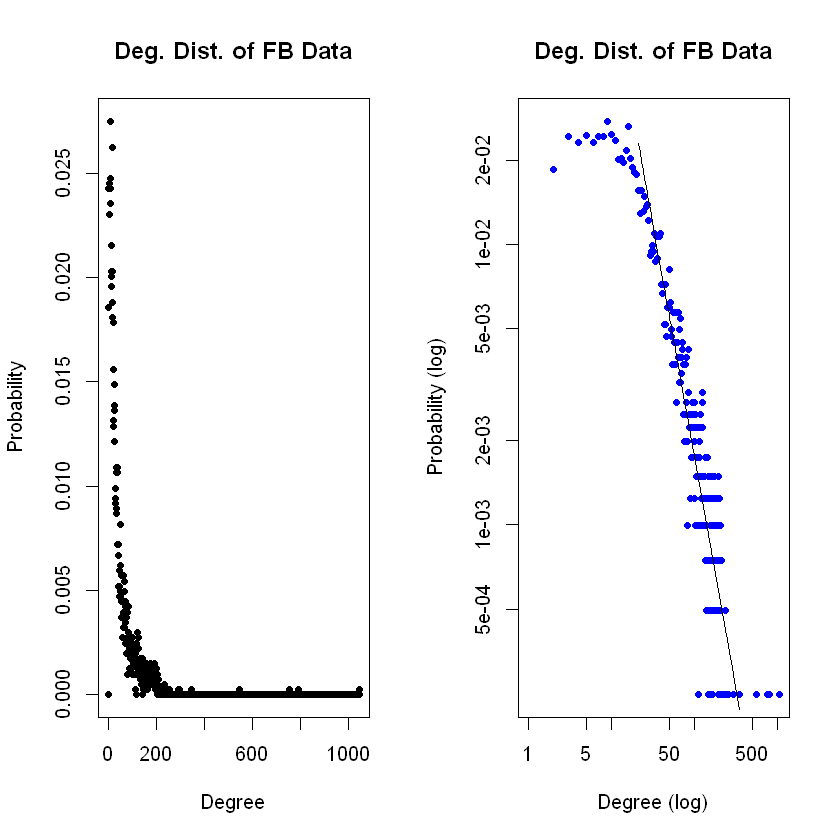

In [77]:
is.connected(g)
vcount(g)
diameter(g)
d<-degree(g)
mean(d)

par(mfrow=c(1,2)) #formatting

dist<-degree.distribution(g)
plot(dist,xlab='Degree',ylab='Probability',main='Deg. Dist. of FB Data',cex=0.8,pch=16)

degs<-which(dist!=0)
degs_outlier<-degs[log(degs)>3 & log(degs)< 6] # removes some outliers for the fit
fit<-lm(log(dist[degs_outlier]) ~ log(degs_outlier))
yfit<-fit$fitted.values
plot(dist,log='xy',xlab='Degree (log)',ylab='Probability (log)',main='Deg. Dist. of FB Data',cex=0.8,pch=16,col='blue')
lines(degs_outlier, exp(yfit))
degs<-seq(1,length(dist))

fit$coefficients[2] # contains the slope

To answer the questions: 
1. The Facebook graph is connected. As such, the GCC is the whole graph, which contains all 4039 nodes in it. 
2. The diameter of the network is 8. 
3. The average degree of the network is 43.7. 
4. Here, the slope of the log-log plot for the degree distribution is approximately -1.66, which means that the power coefficient is not in the range where the distribution is heavy-tailed. 

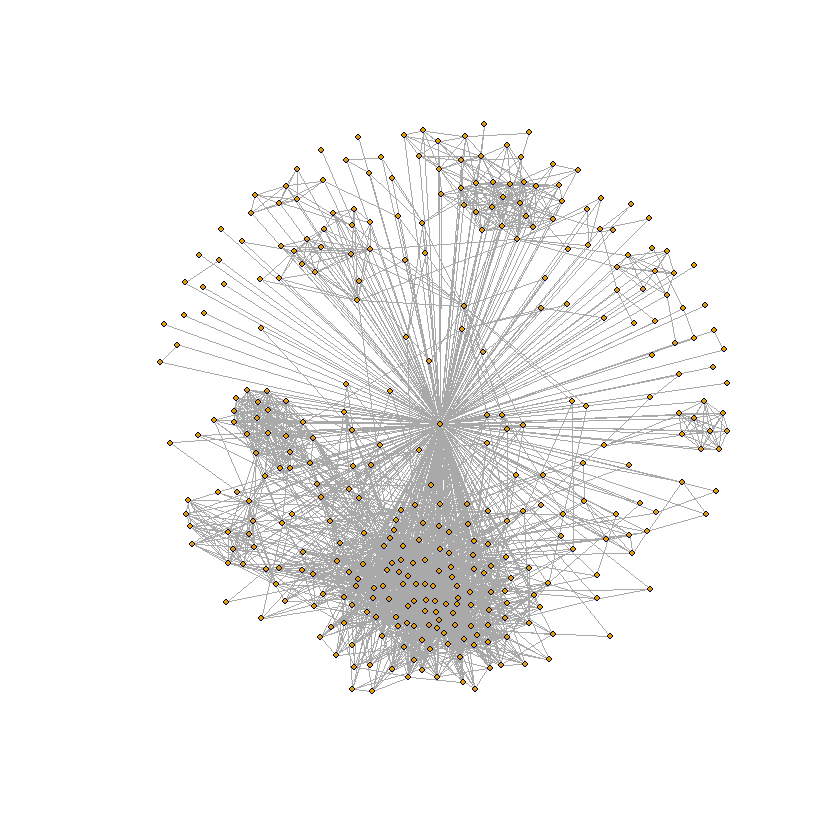

In [100]:
n <- 1 # node we are interested in. 
m <- seq(1,vcount(g))
m <- m[!(m == n |m %in% neighbors(g,n))] # gets all vertices that are not in the network. 
V(g)$vid <- seq(1,vcount(g))
g1 <- delete.vertices(g, m)
plot(g1, vertex.label=V(g1)$vid, vertex.size=2,vertex.label.cex=0.1)

In [102]:
vcount(g1)
ecount(g1)
diameter(g1)

[1] 348

[1] 2866

[1] 2

5. Here, there are 348 nodes and 2866 edges. 
6. The diameter of the network is 2. The minimum for the diameter of the network is 1. The maximum for the diameter is 2. 
7. This is because there will always be a path of length 2 between any two nodes - through the center of the personal network and to any other node. The only case where the diameter of the network is 1 is if the network is completely connected (I think?)

In [103]:
# 1.3
g.degs<-degree(g)
core.degs<-g.degs[g.degs>200]
n_core=length(core.degs)
mean_core=mean(core.degs)
n_core
mean_core

[1] 40

[1] 279.375

8. There are 40 core nodes in this graph, with an average degree of 279.4. 

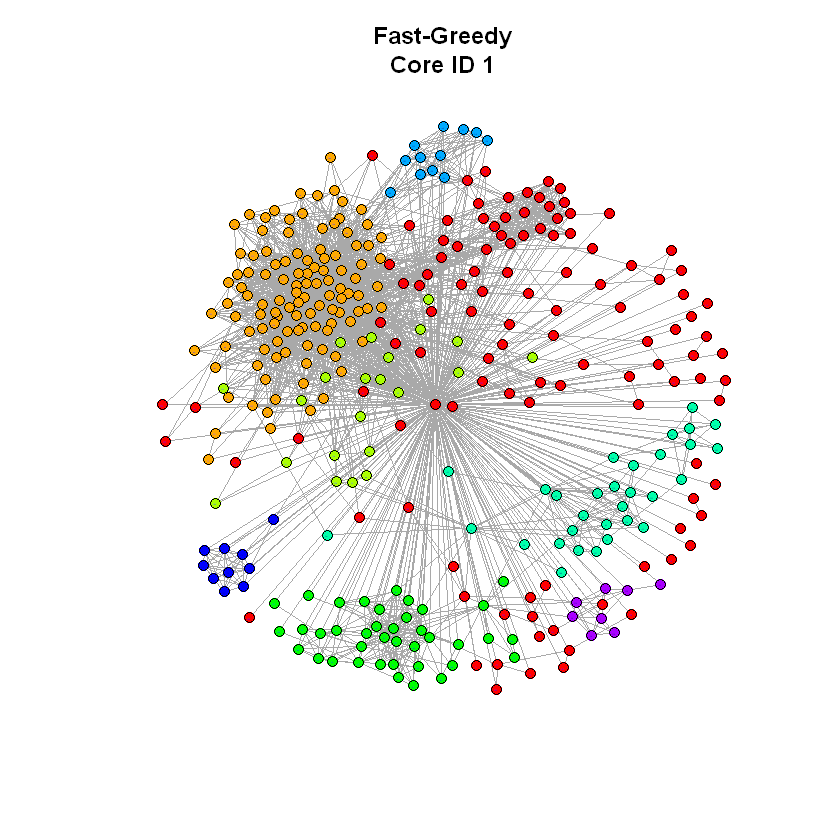

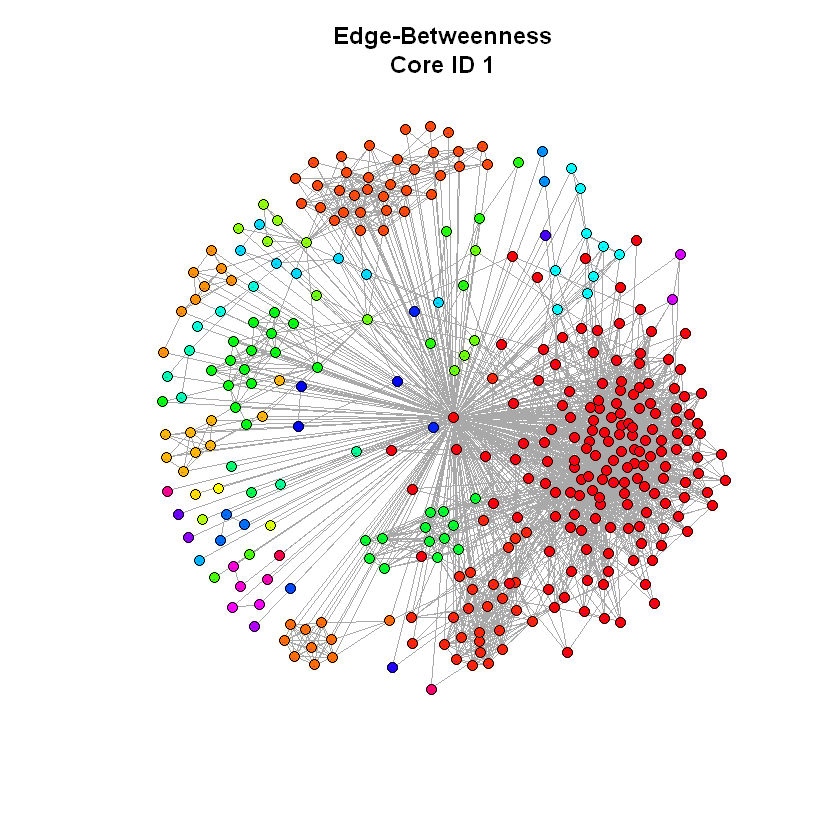

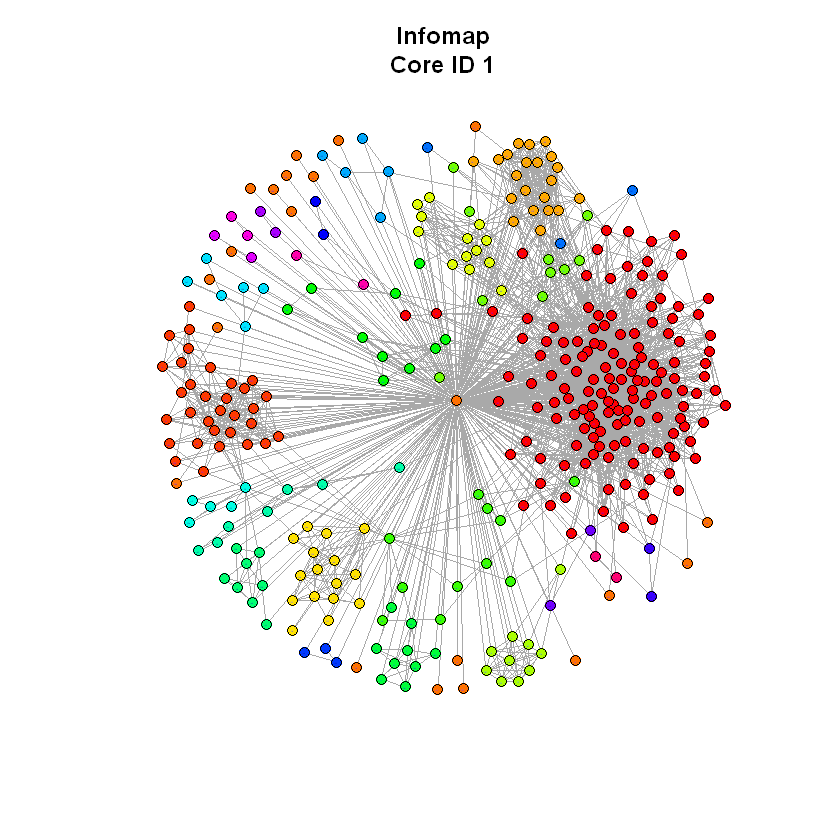

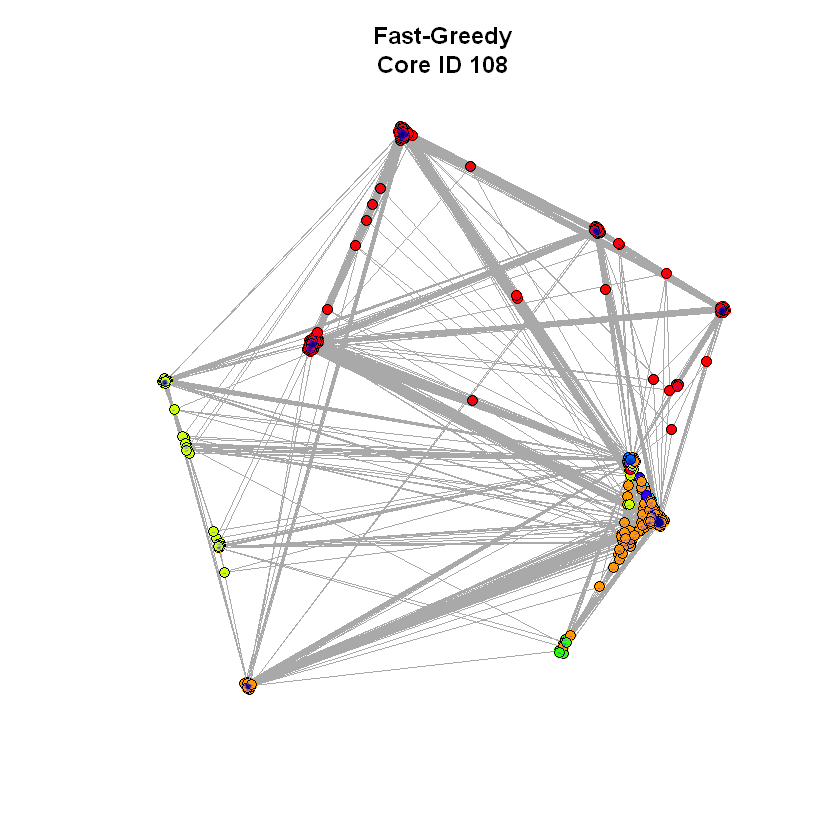

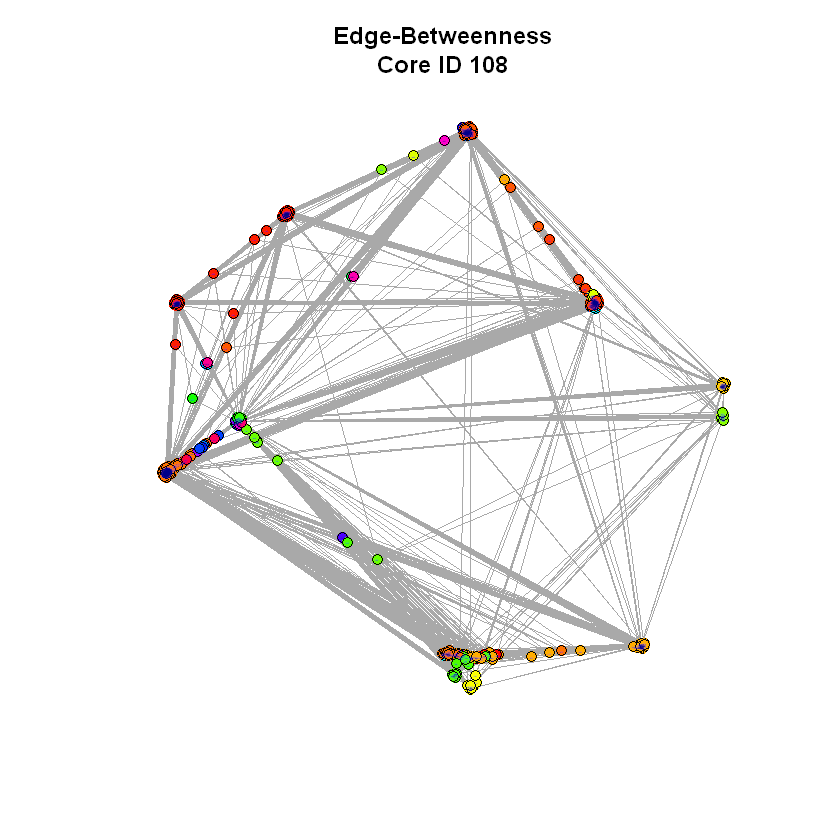

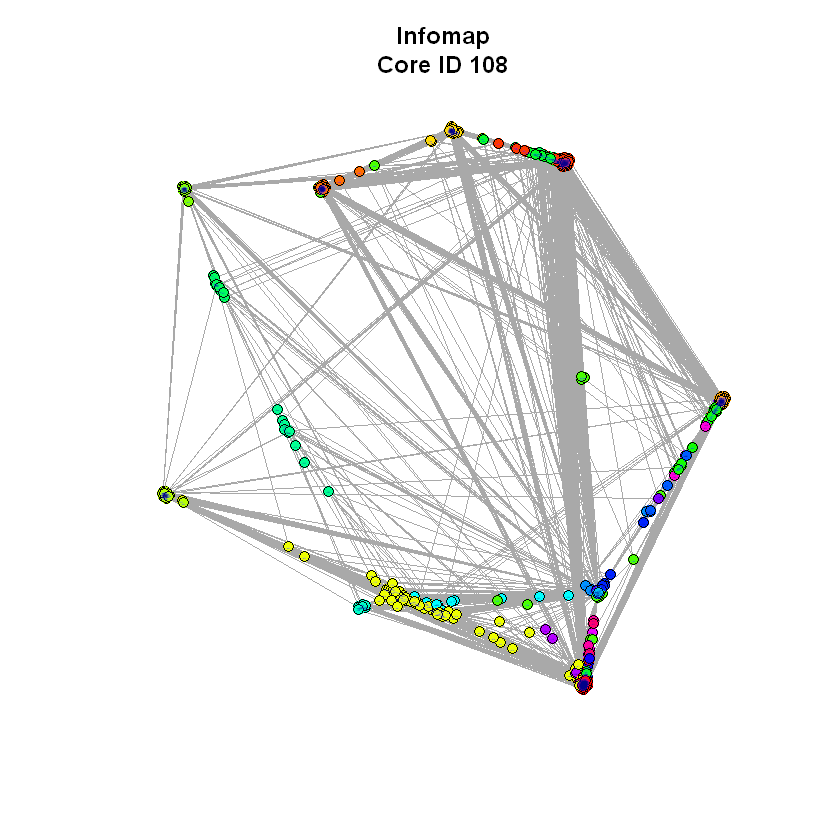

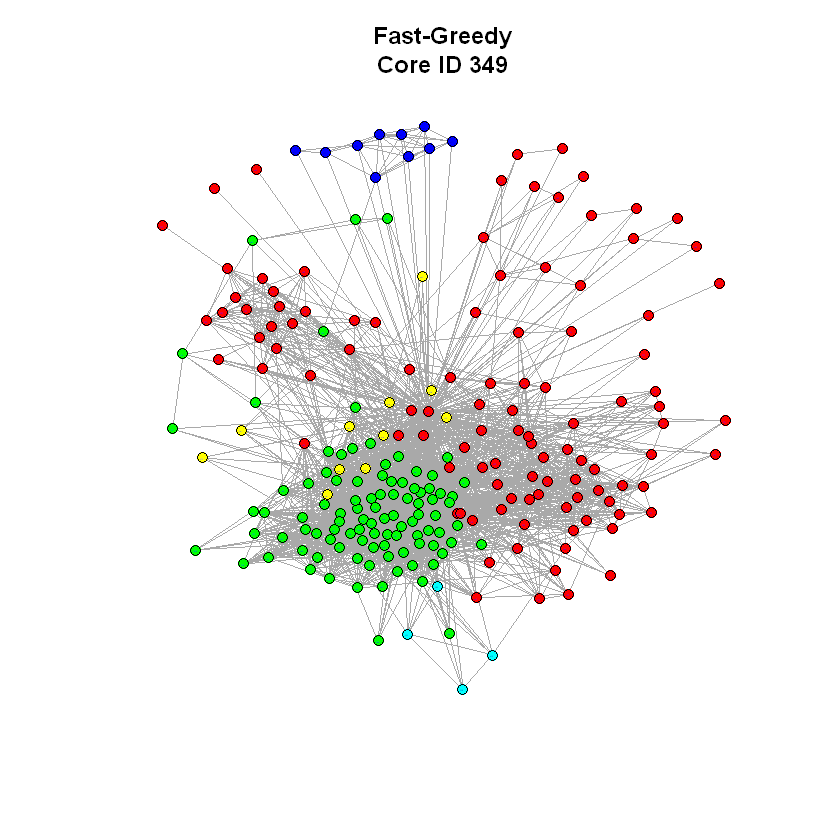

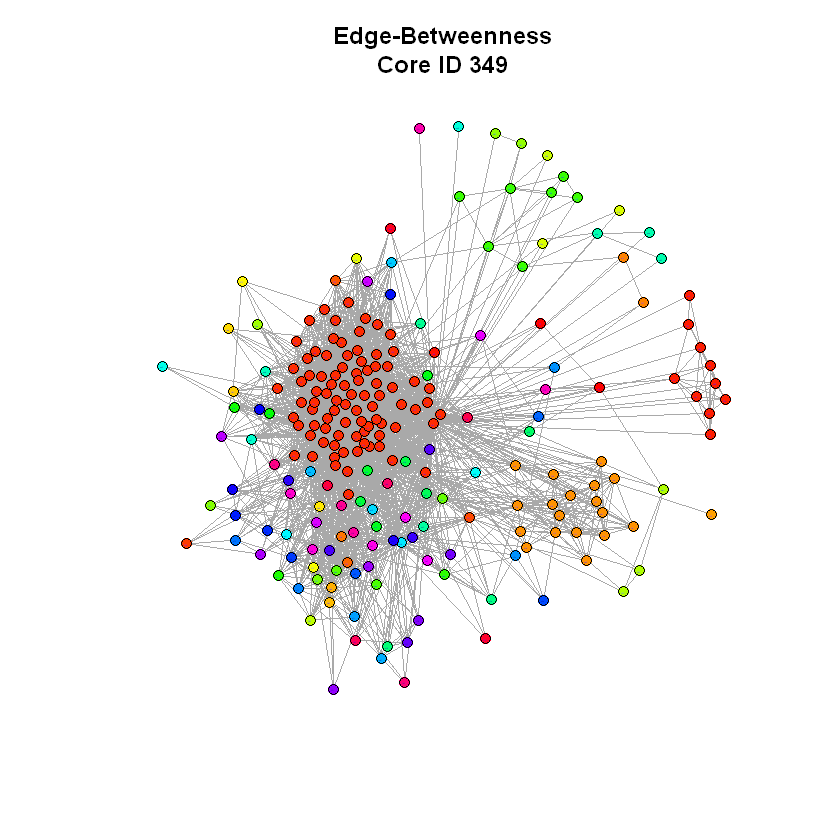

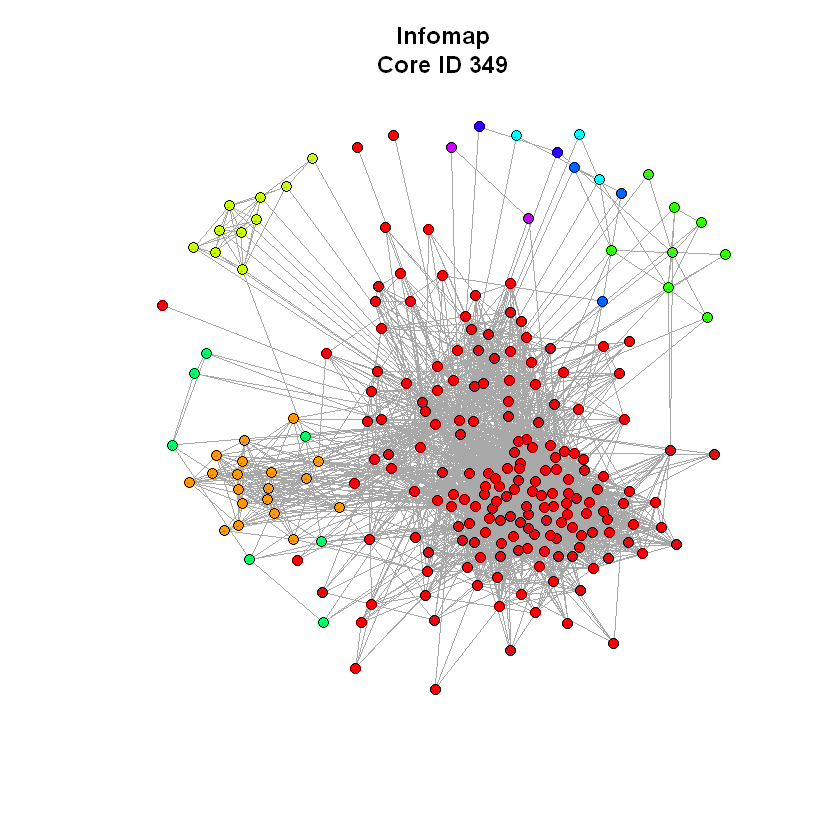

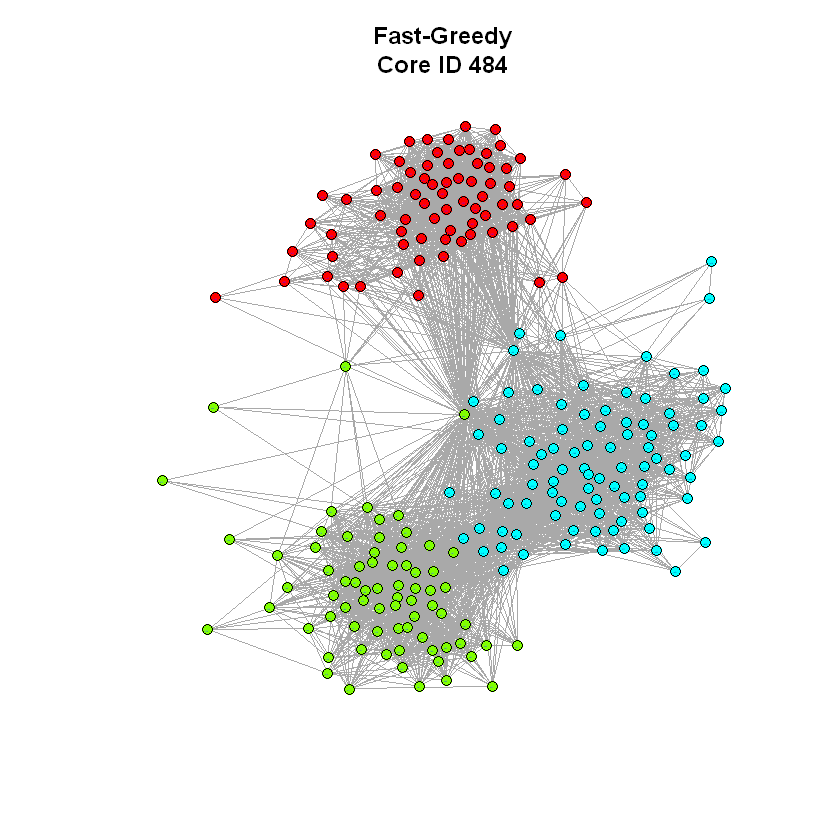

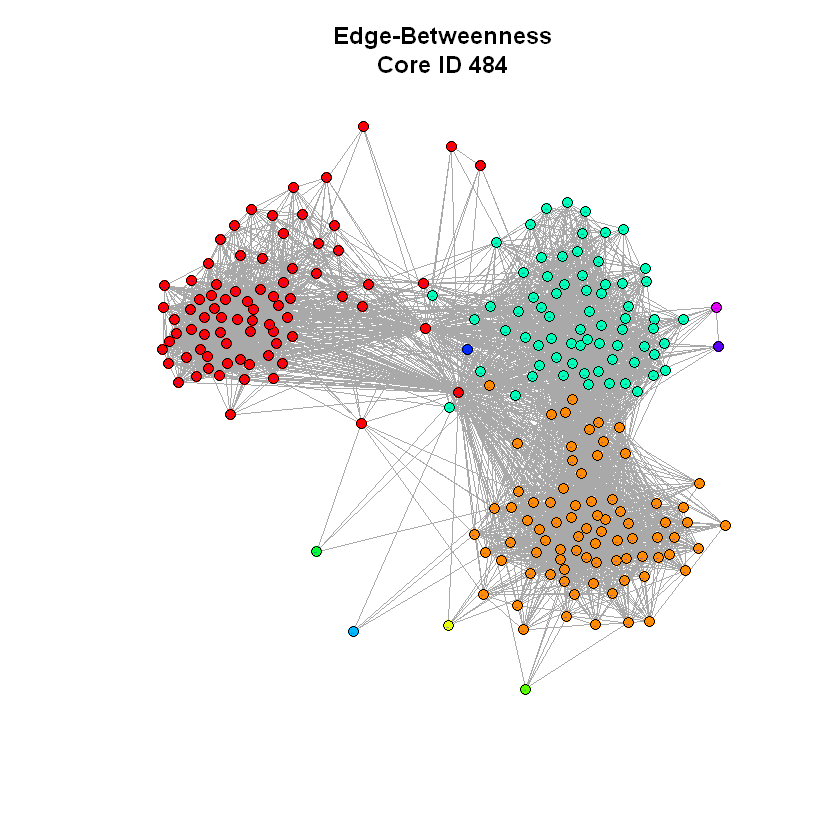

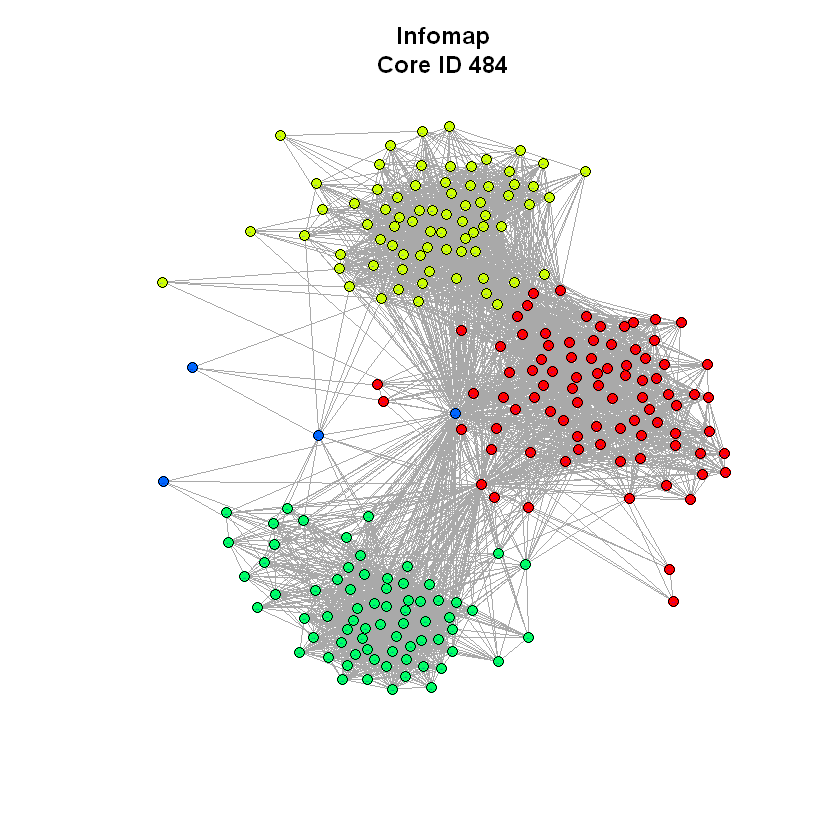

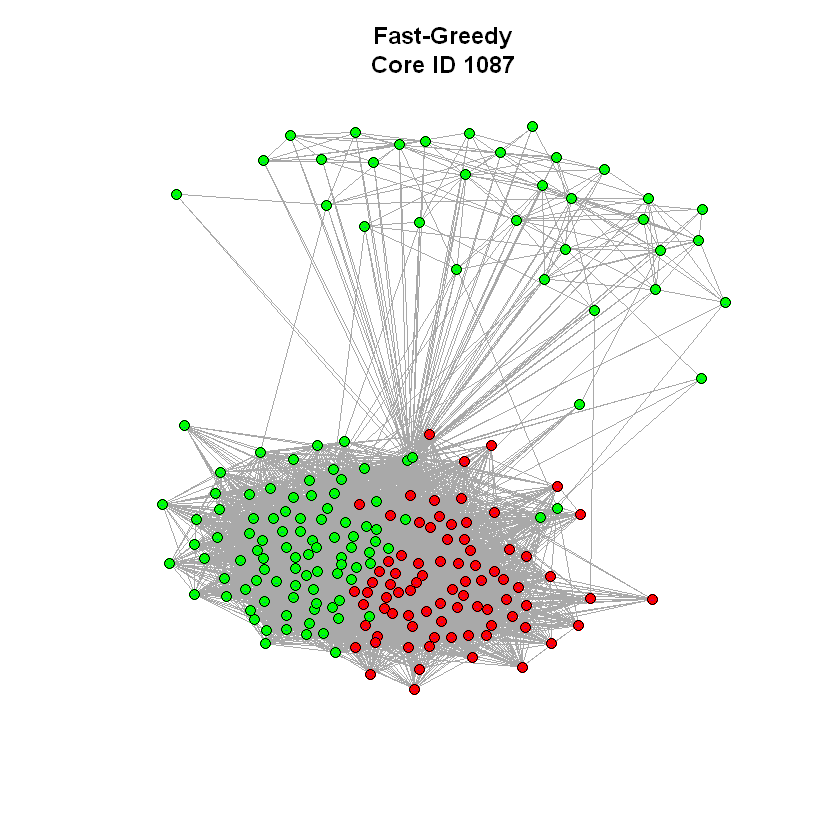

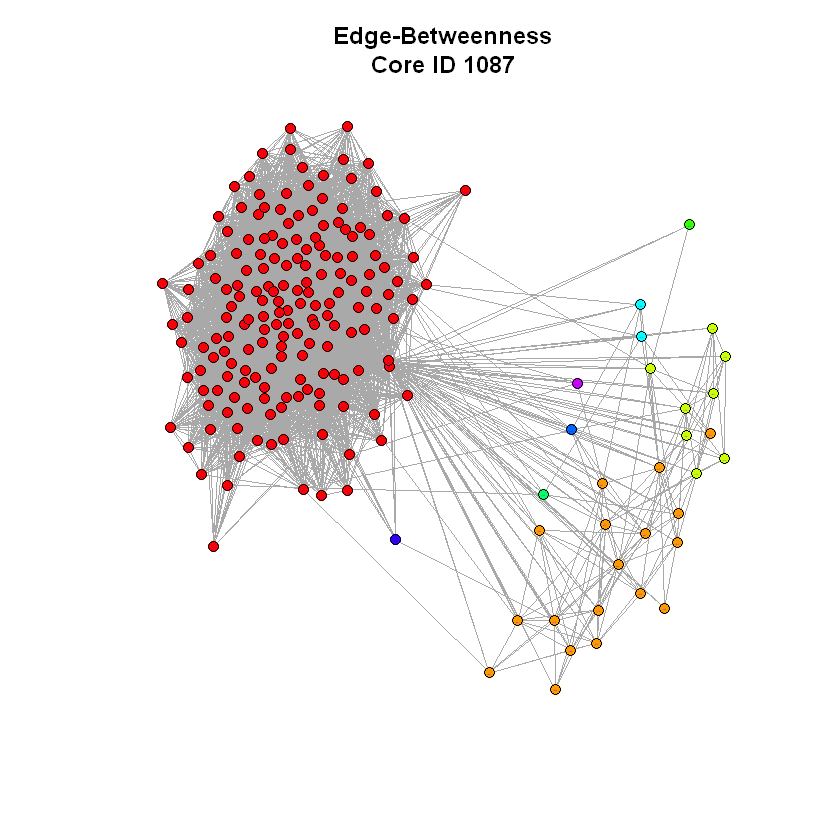

Core.ID.Node,Fast.Greedy.Modularity,Edge.Betweenness.Modularity,Infomap.Modularity
1,0.4131014,0.35330217,0.38911847
108,0.4359294,0.50675492,0.50822334
349,0.2517149,0.13352802,0.09546420
484,0.5070016,0.48909518,0.51527875
1087,0.1455315,0.02762377,0.02690662


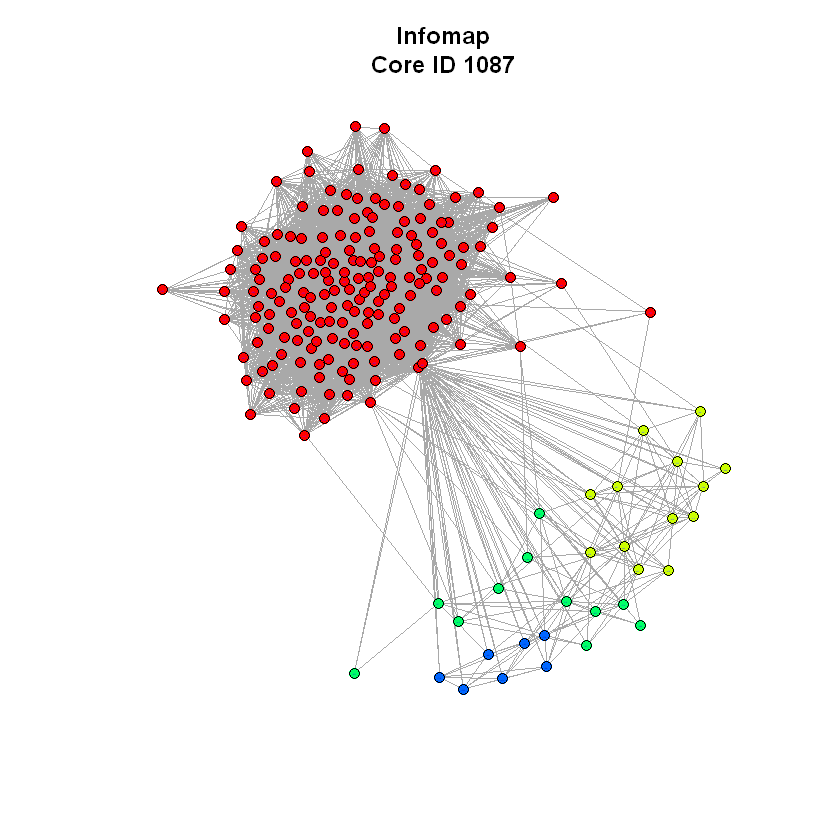

In [105]:
# 1.3.1
core_ids=c(1,108,349,484,1087)
fg.mods=numeric(5)
eb.mods=numeric(5)
im.mods=numeric(5)
for (n in core_ids){
    m <- seq(1,vcount(g))
    m <- m[!(m == n |m %in% neighbors(g,n))] #not connected to n
    g1 <- delete.vertices(g, m)
    
    fg<-cluster_fast_greedy(g1)
    fg.mods[match(n,core_ids)]=max(fg$mod)
    colors = rainbow(size(groups(fg))+1)
    nodes_colors = colors[1:(length(colors)-1)]
    V(g1)$color = nodes_colors[membership(fg)]
    plot(g1,vertex.label=V(g1)$vid, vertex.size=4,vertex.label.cex=0.1,main=paste("Fast-Greedy","\n", "Core ID ",n,sep=""))
    
    eb<-cluster_edge_betweenness(g1)
    eb.mods[match(n,core_ids)]=max(eb$mod)
    colors = rainbow(size(groups(eb))+1)
    nodes_colors = colors[1:(length(colors)-1)]
    V(g1)$color = nodes_colors[membership(eb)]
    plot(g1,vertex.label=V(g1)$vid, vertex.size=4,vertex.label.cex=0.1,main=paste("Edge-Betweenness","\n", "Core ID ",n,sep=""))
    
    im<-cluster_infomap(g1)
    im.mods[match(n,core_ids)]=max(im$mod)
    colors = rainbow(size(groups(im))+1)
    nodes_colors = colors[1:(length(colors)-1)]
    V(g1)$color = nodes_colors[membership(im)]
    plot(g1,vertex.label=V(g1)$vid, vertex.size=4,vertex.label.cex=0.1,main=paste("Infomap","\n", "Core ID ",n,sep=""))
}
data.frame("Core ID Node"=core_ids,"Fast-Greedy Modularity"=fg.mods,"Edge-Betweenness Modularity"=eb.mods,"Infomap Modularity"=im.mods)

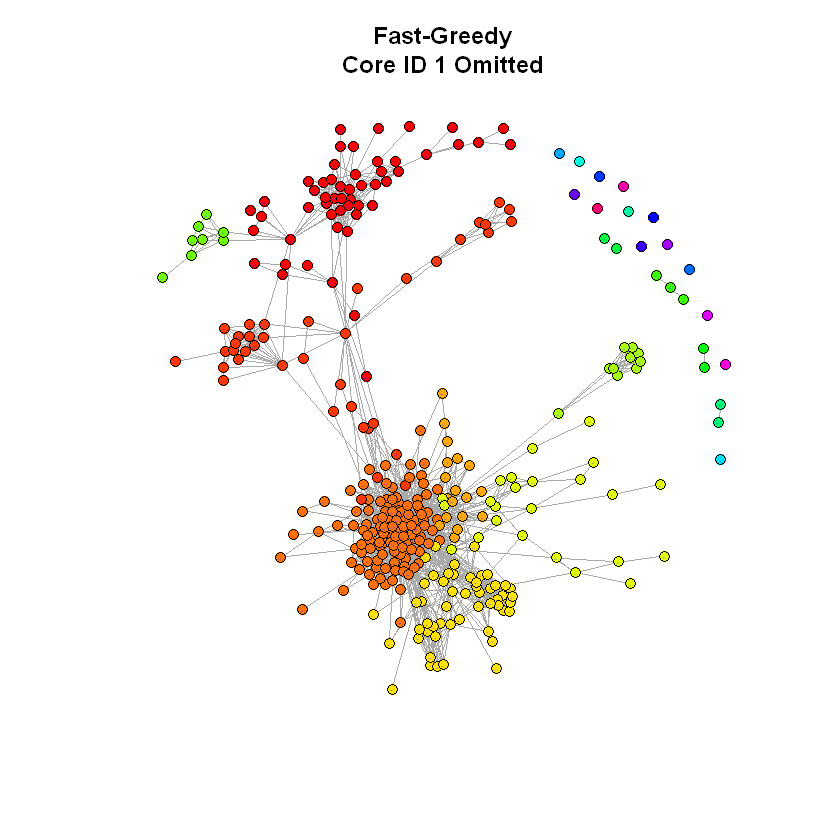

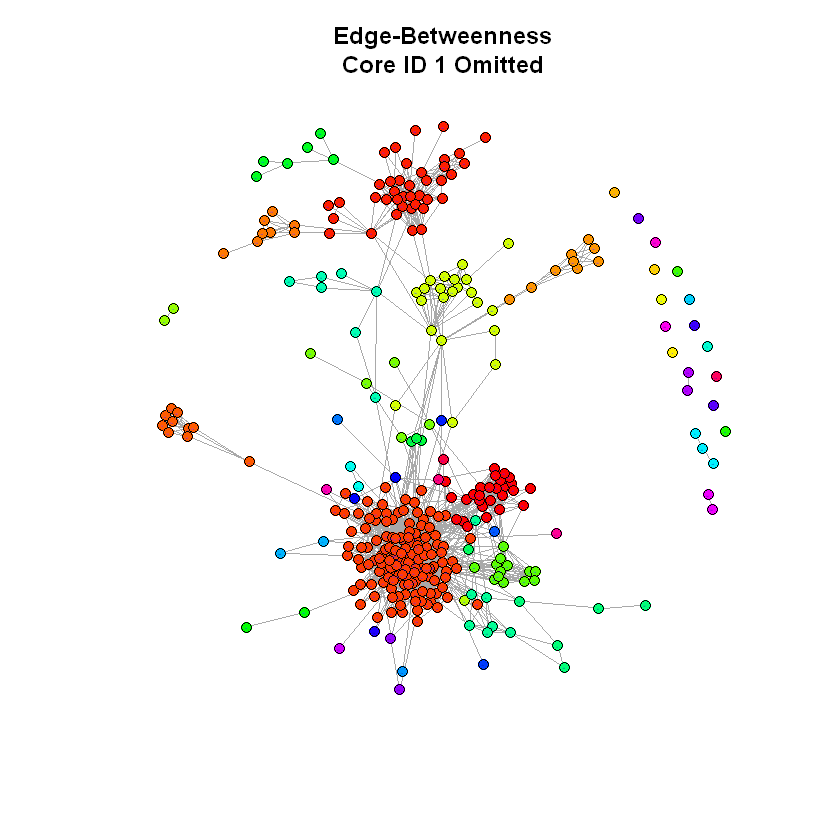

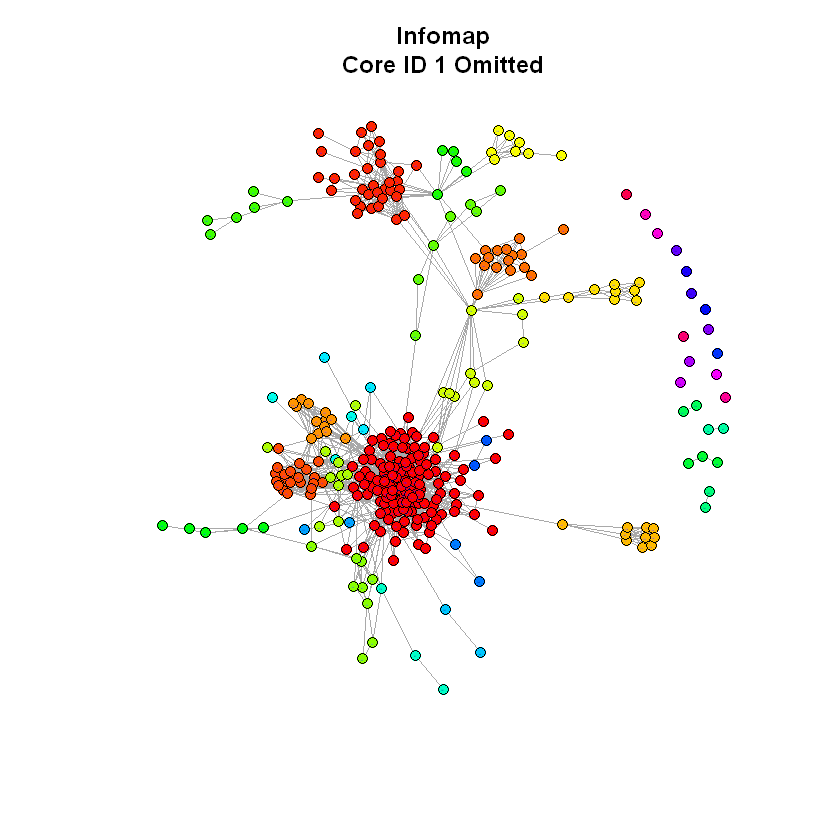

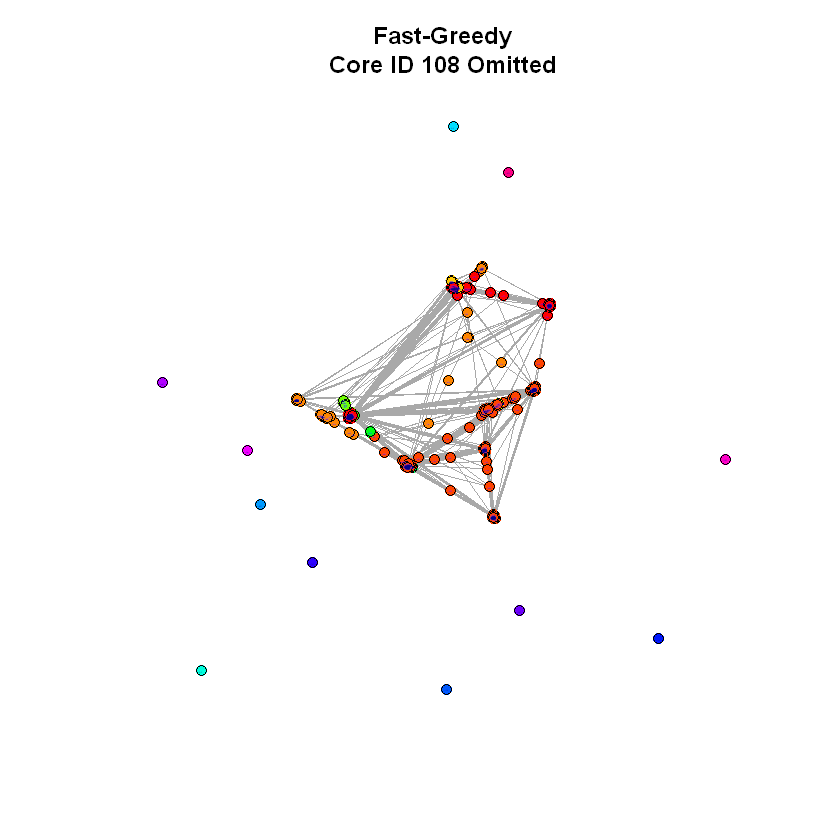

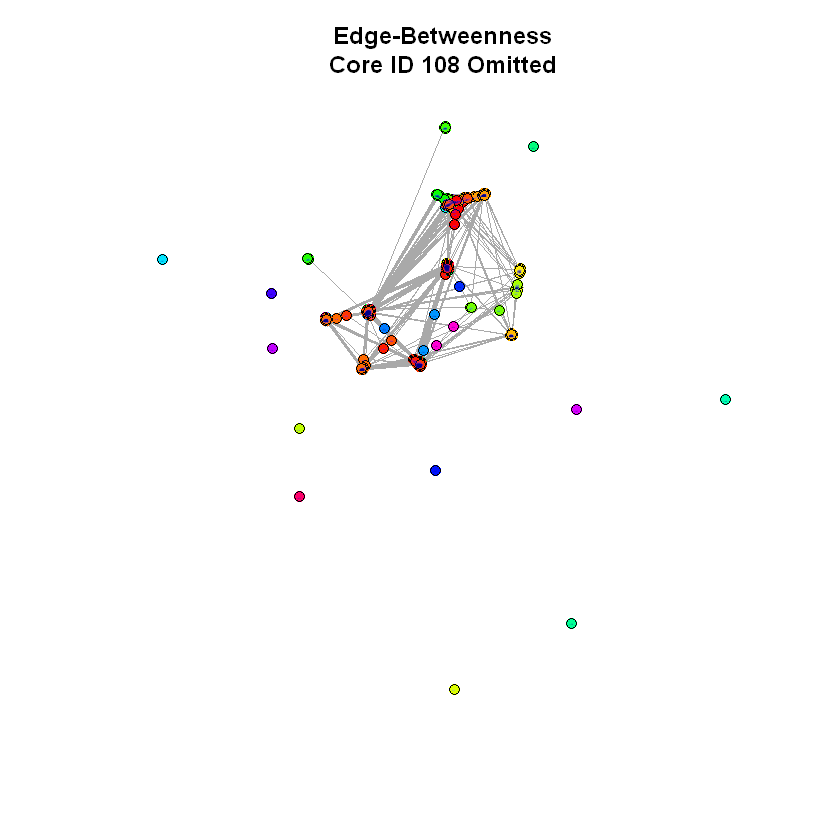

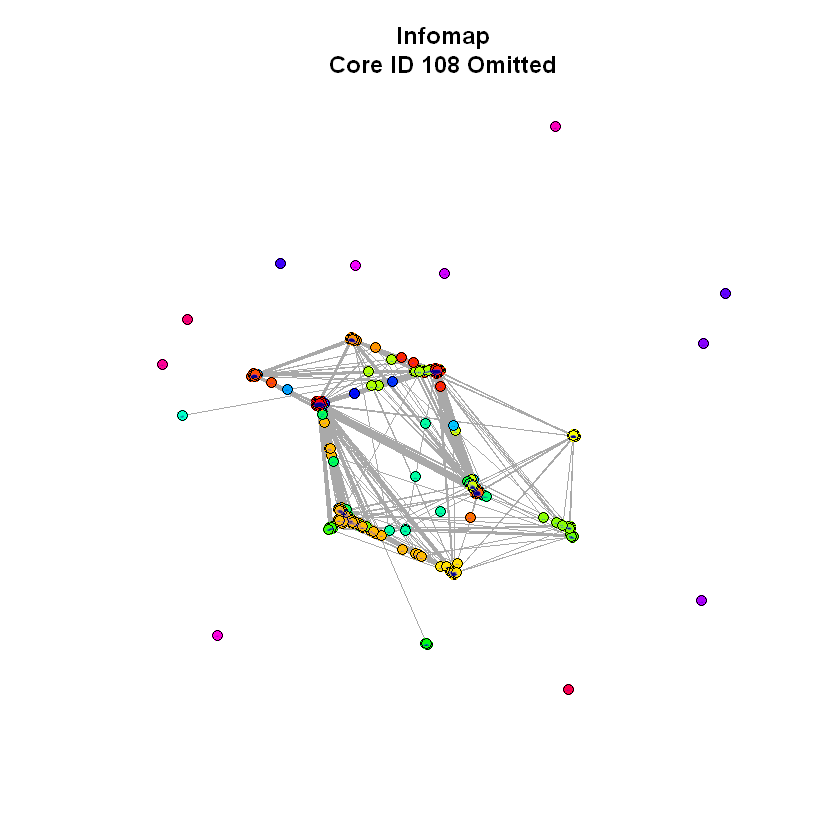

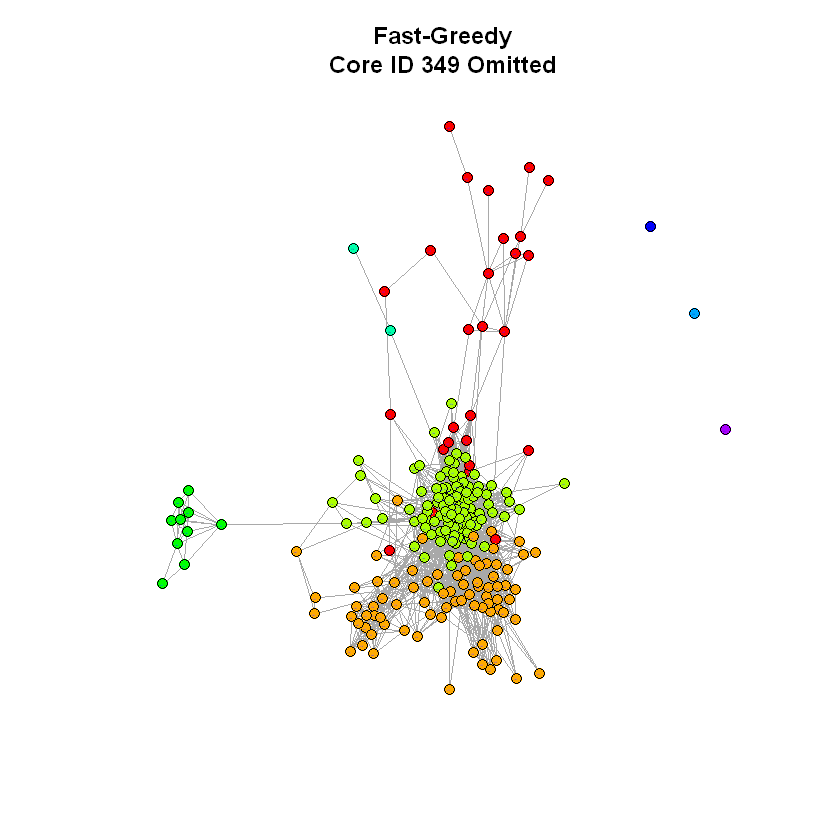

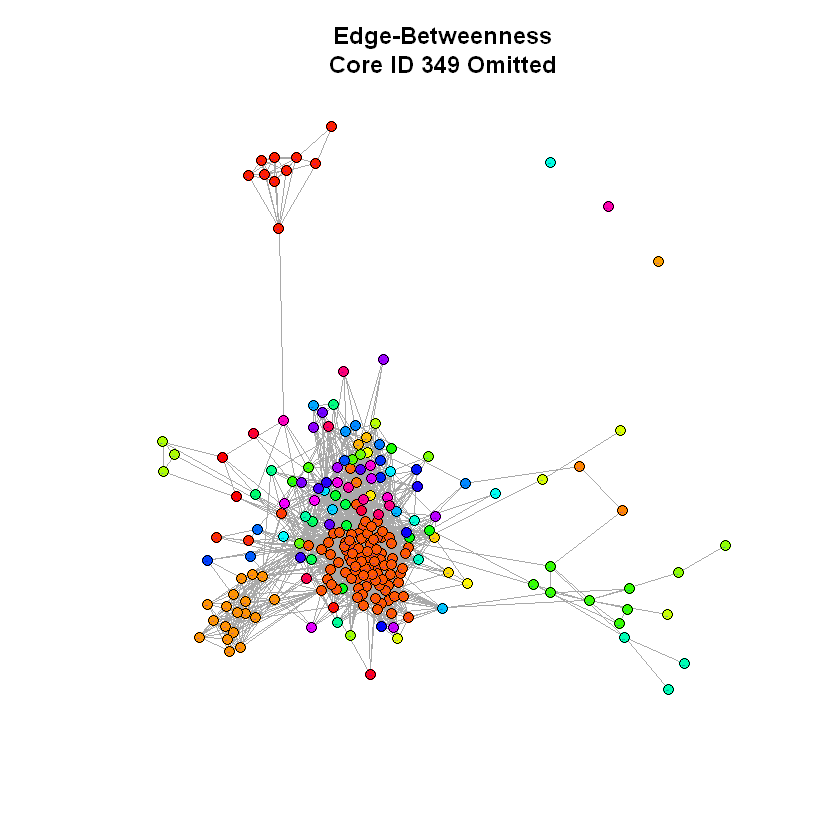

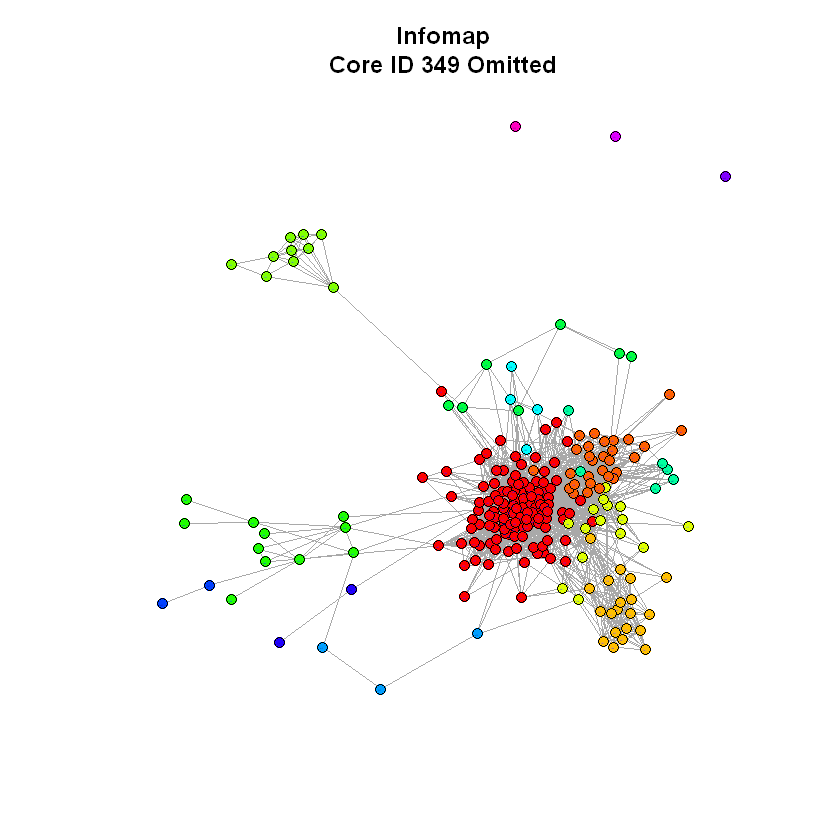

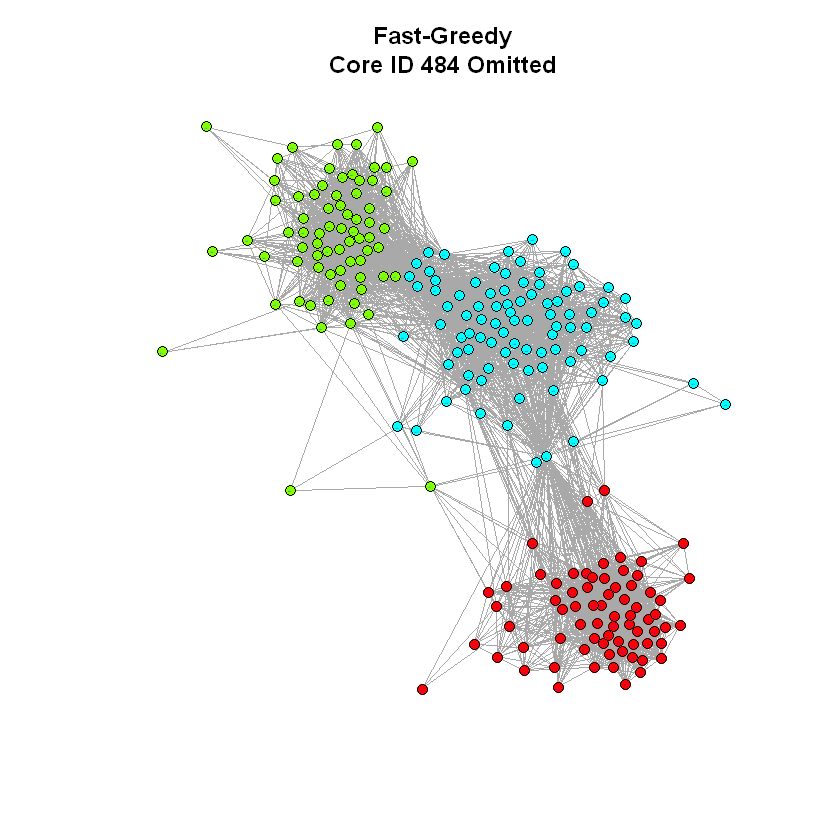

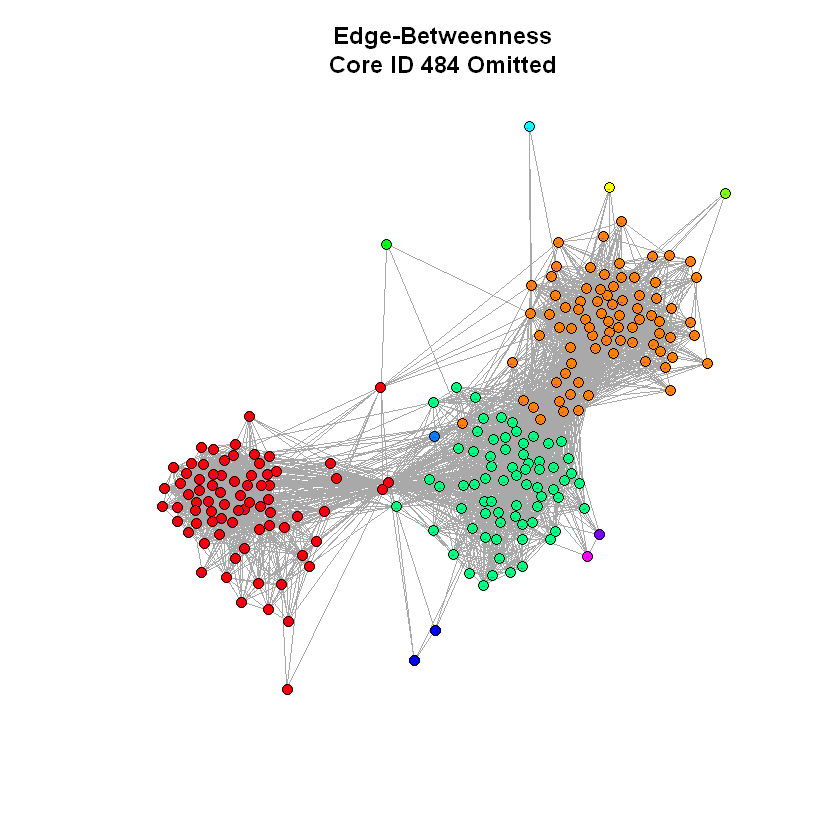

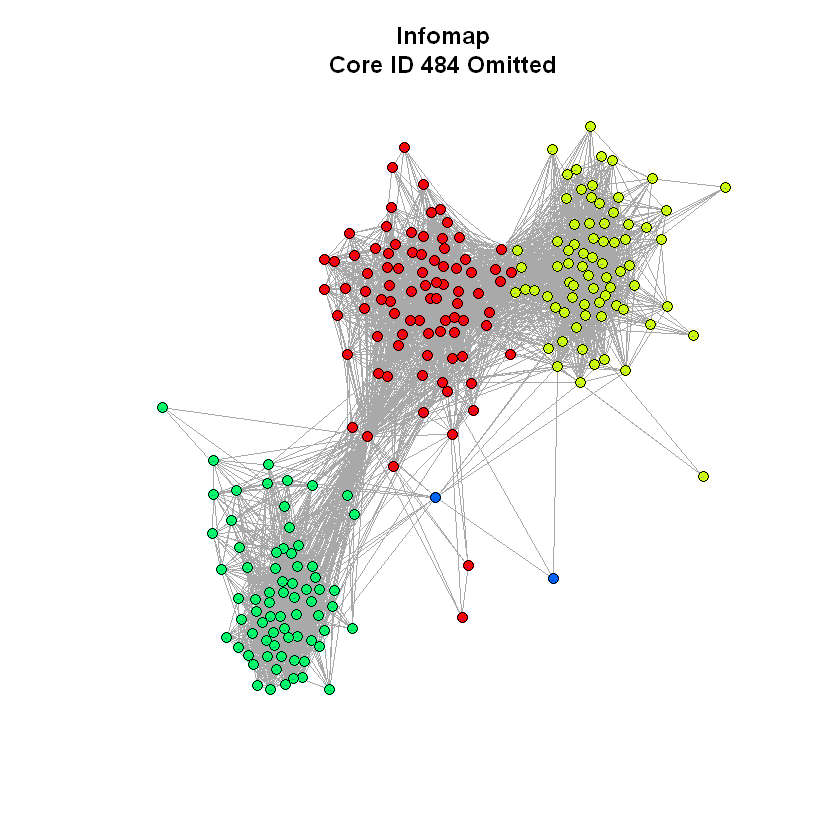

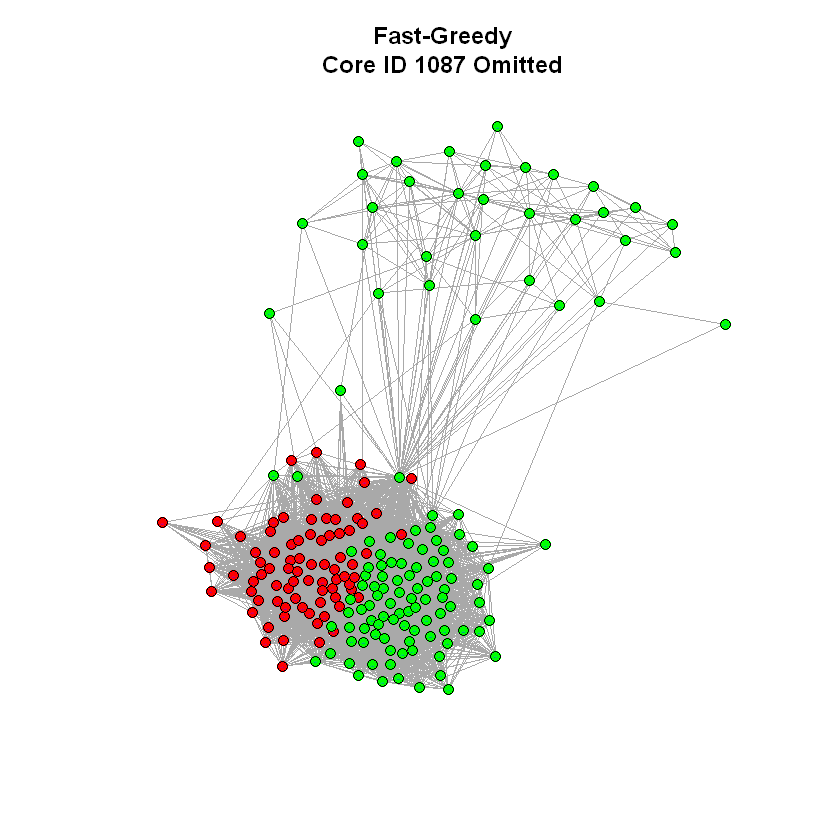

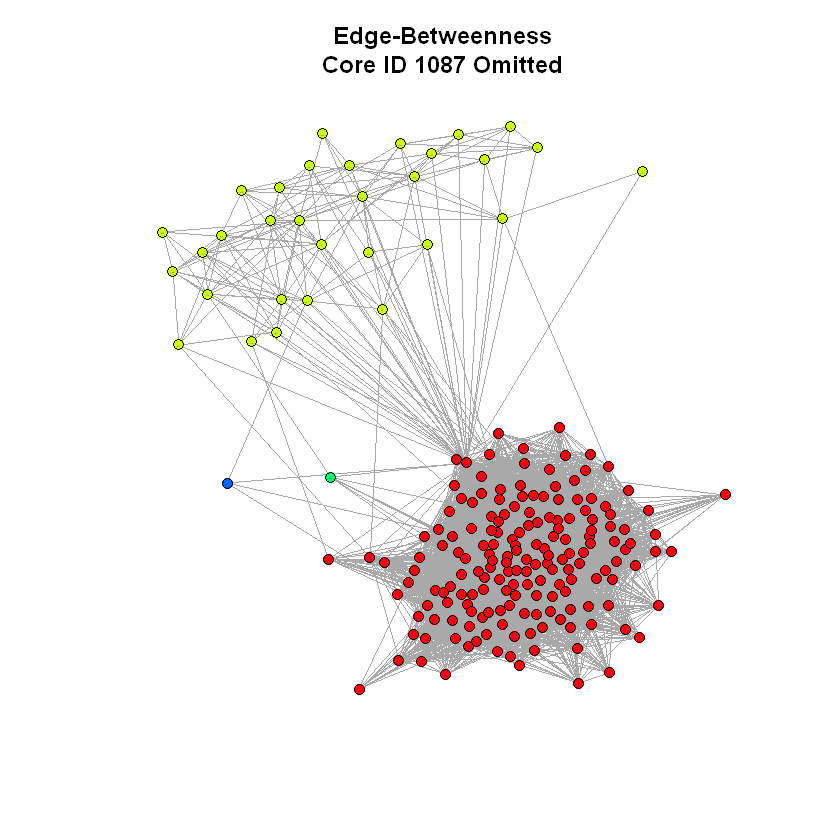

Core.ID.Node,Fast.Greedy.Modularity,Edge.Betweenness.Modularity,Infomap.Modularity
1,0.4418533,0.4161461,0.41800766
108,0.4581271,0.5213216,0.52051712
349,0.2456918,0.1505663,0.24481562
484,0.5342142,0.5154413,0.54344368
1087,0.1481956,0.0324953,0.02777604


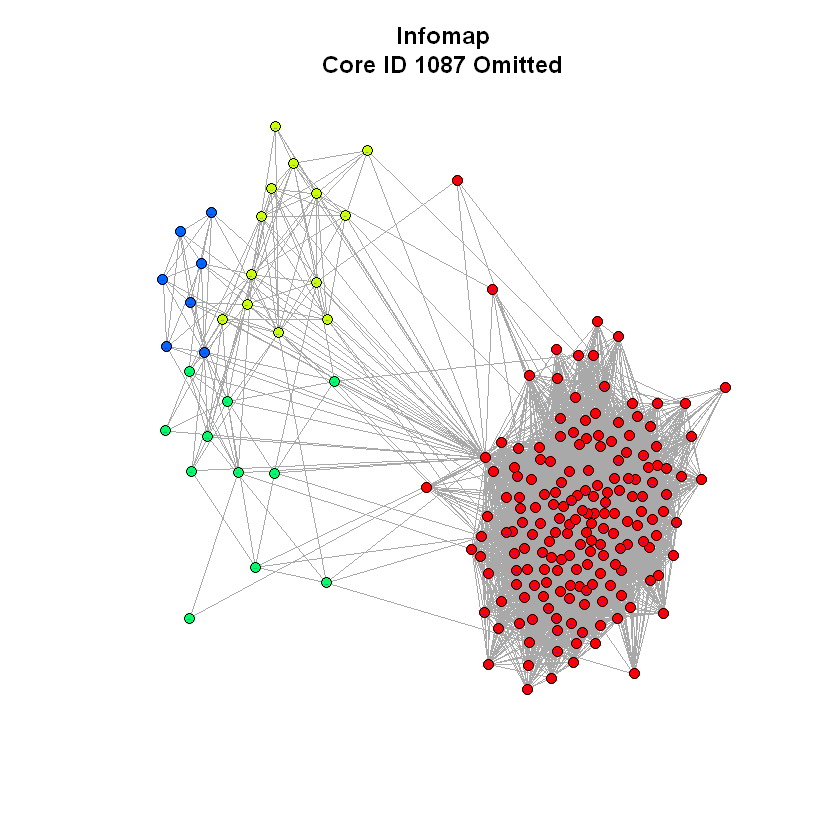

In [106]:
# 1.3.2, now omitting core nodes from their personalized networks
core_ids=c(1,108,349,484,1087)
fg.mods=numeric(5)
eb.mods=numeric(5)
im.mods=numeric(5)
for (n in core_ids){
    m <- seq(1,vcount(g))
    m <- m[!(m %in% neighbors(g,n))] #not connected to n
    g1 <- delete.vertices(g, m)
    
    fg<-cluster_fast_greedy(g1)
    fg.mods[match(n,core_ids)]=max(fg$mod)
    colors = rainbow(size(groups(fg))+1)
    nodes_colors = colors[1:(length(colors)-1)]
    V(g1)$color = nodes_colors[membership(fg)]
    plot(g1,vertex.label=V(g1)$vid, vertex.size=4,vertex.label.cex=0.1,main=paste("Fast-Greedy","\n", "Core ID ",n," Omitted",sep=""))
    
    eb<-cluster_edge_betweenness(g1)
    eb.mods[match(n,core_ids)]=max(eb$mod)
    colors = rainbow(size(groups(eb))+1)
    nodes_colors = colors[1:(length(colors)-1)]
    V(g1)$color = nodes_colors[membership(eb)]
    plot(g1,vertex.label=V(g1)$vid, vertex.size=4,vertex.label.cex=0.1,main=paste("Edge-Betweenness","\n", "Core ID ",n," Omitted",sep=""))
    
    im<-cluster_infomap(g1)
    im.mods[match(n,core_ids)]=max(im$mod)
    colors = rainbow(size(groups(im))+1)
    nodes_colors = colors[1:(length(colors)-1)]
    V(g1)$color = nodes_colors[membership(im)]
    plot(g1,vertex.label=V(g1)$vid, vertex.size=4,vertex.label.cex=0.1,main=paste("Infomap","\n", "Core ID ",n," Omitted",sep=""))
}
data.frame("Core ID Node"=core_ids,"Fast-Greedy Modularity"=fg.mods,"Edge-Betweenness Modularity"=eb.mods,"Infomap Modularity"=im.mods)

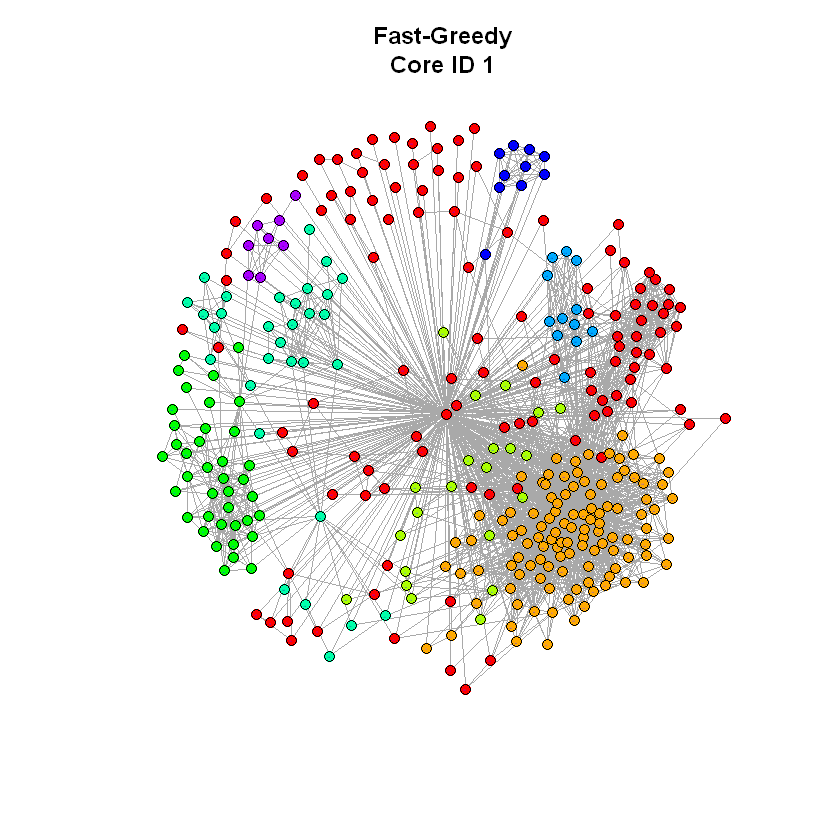

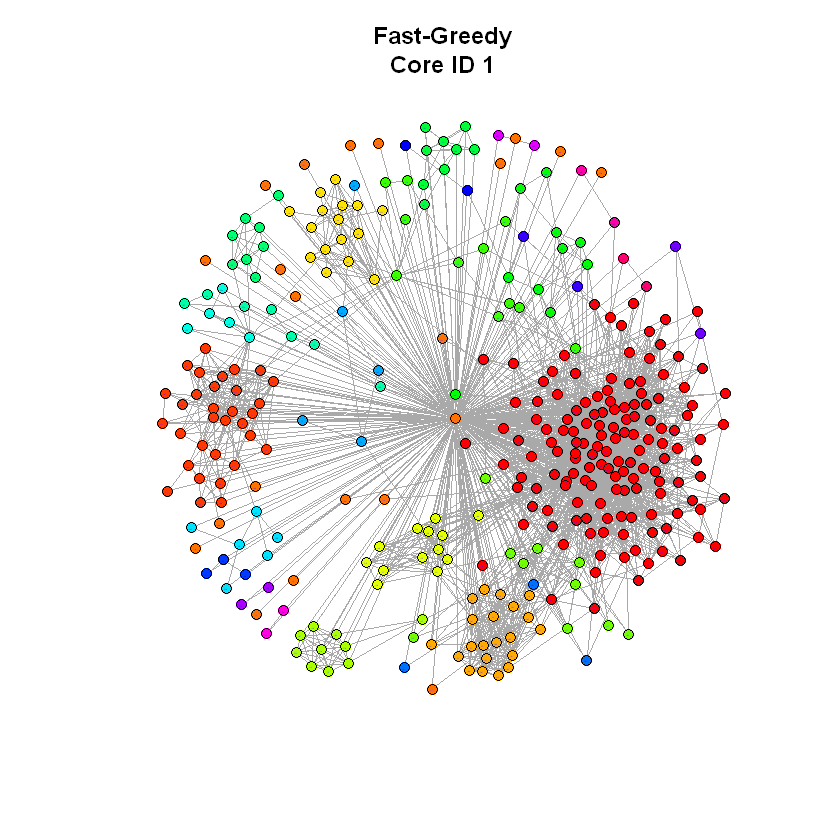

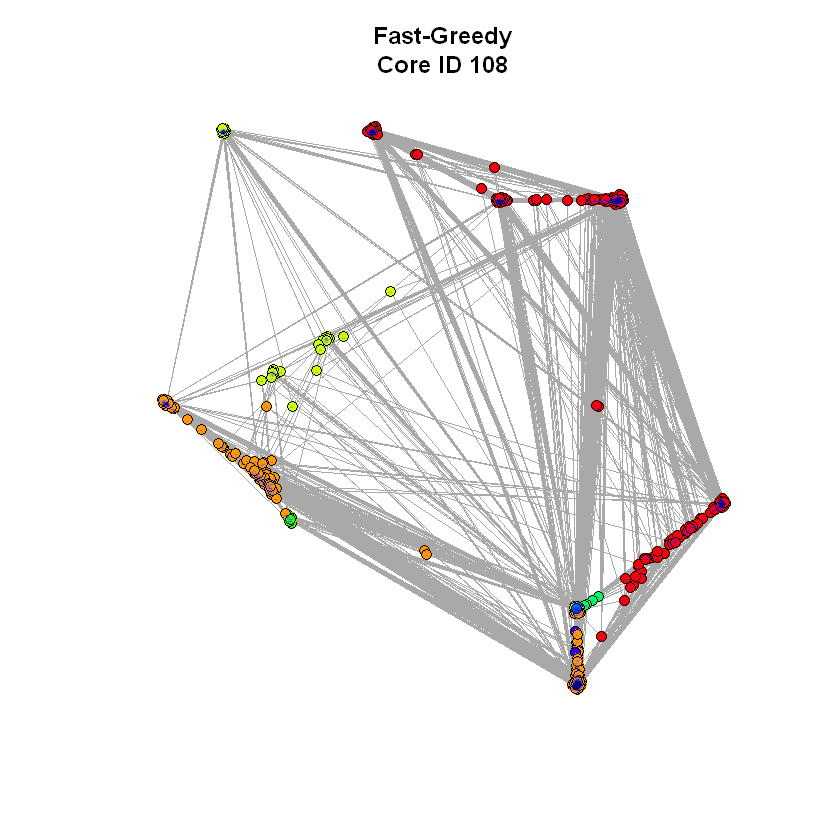

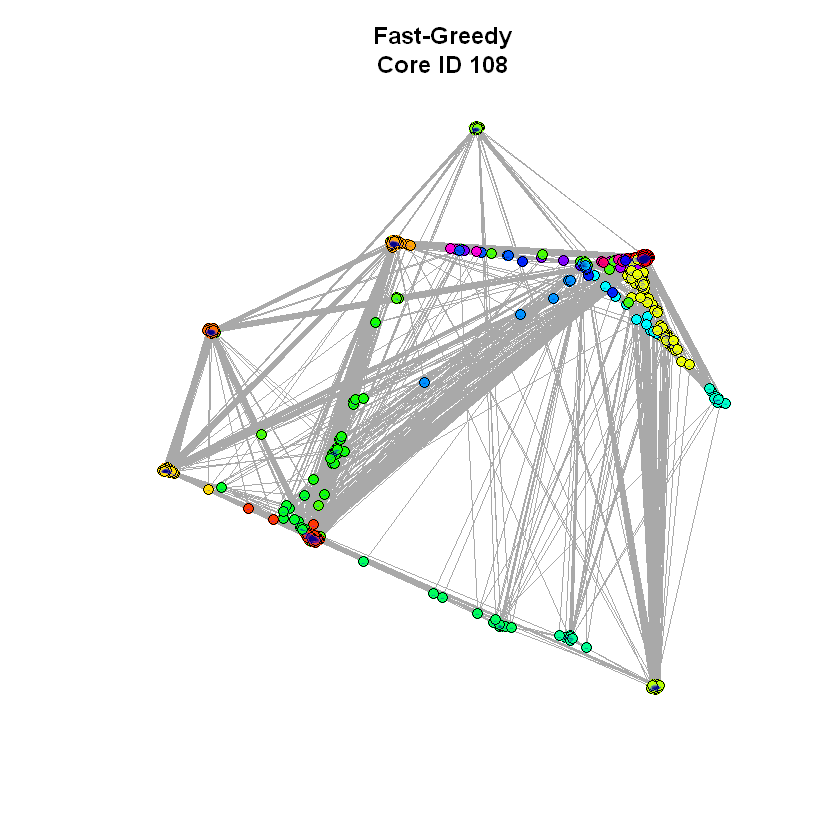

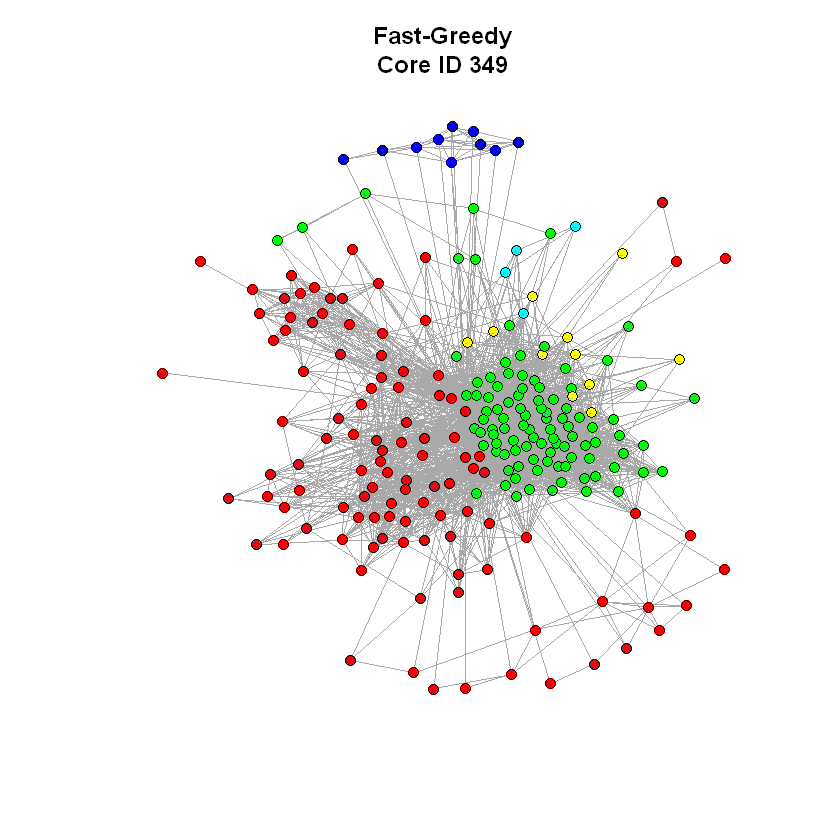

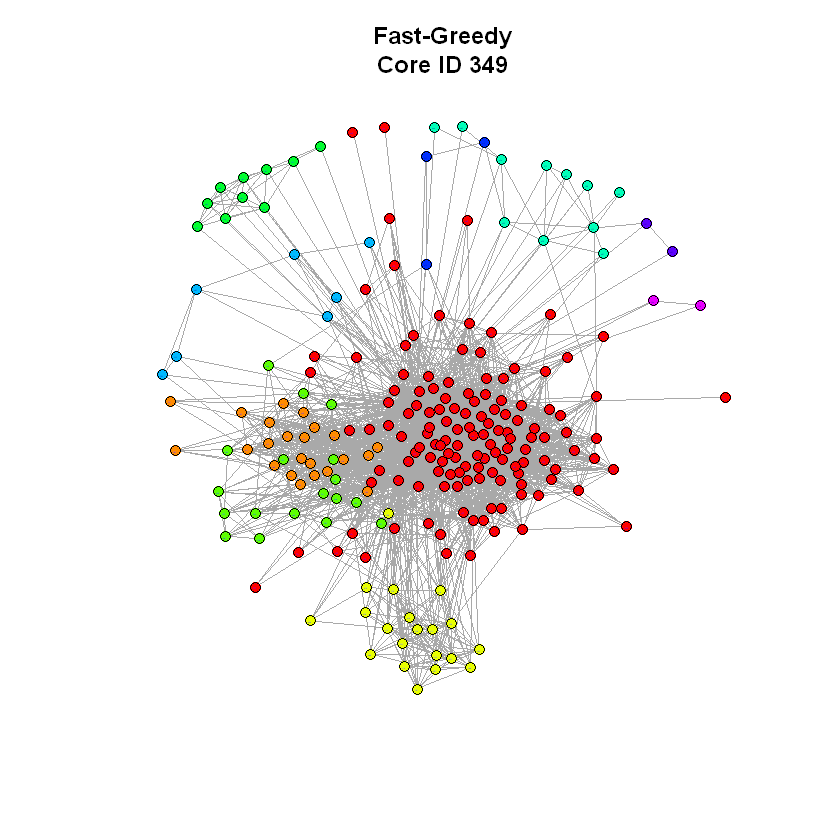

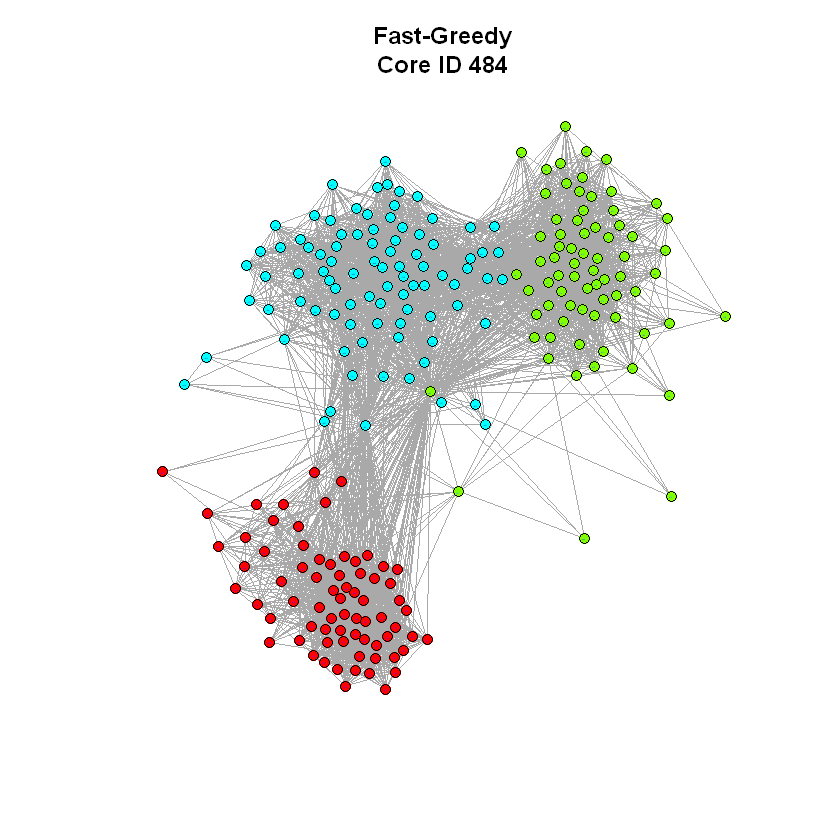

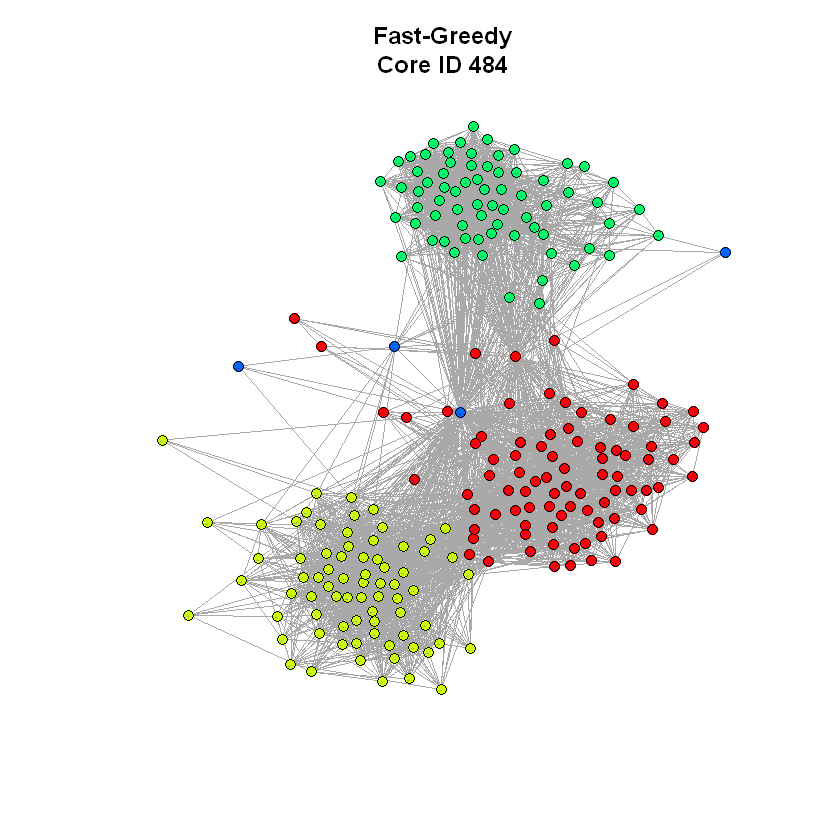

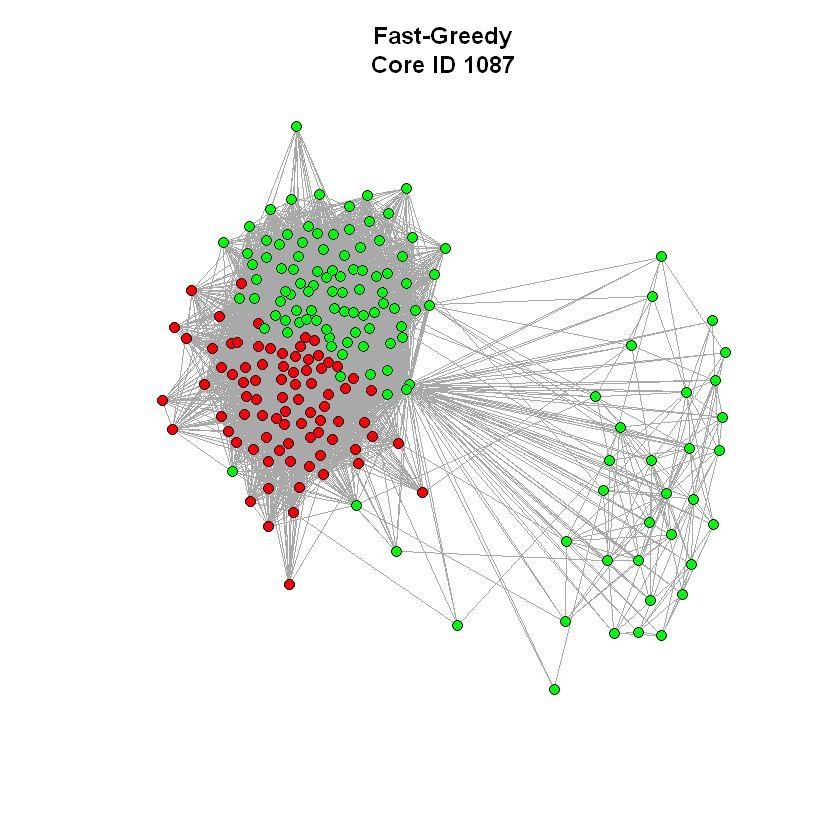

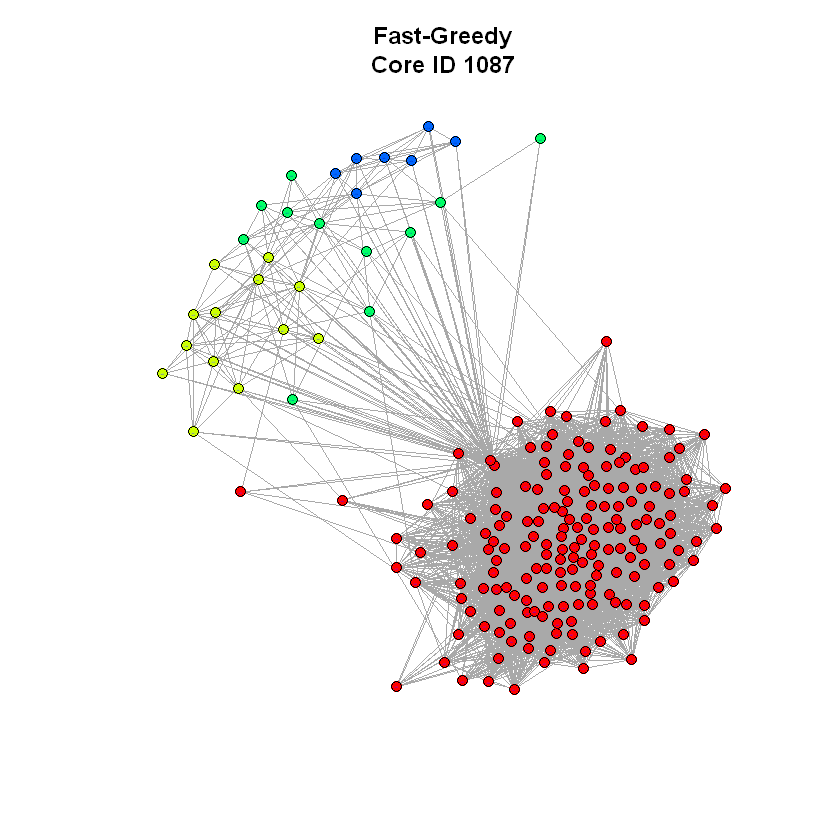

In [218]:
# just a redo of 1.3.1 to see if this is faster. 

core_ids <- c(1,108,349,484,1087)
p_graphs <- lapply(core_ids, create_personalized_network, g)

fg_wcore <- lapply(p_graphs, cluster_fast_greedy)
#eb_wcore <- lapply(p_graphs, cluster_edge_betweenness) # turns out edge_betweenness takes forever. 
im_wcore <- lapply(p_graphs, cluster_infomap)

fg_wcore.mods <- lapply(fg_wcore, function(x) max(x$mod))
#eb_wcore.mods <- lapply(eb_wcore, function(x) max(x$mod))
im_wcore.mods <- lapply(im_wcore, function(x) max(x$mod))
                  
for ( i in 1:length(core_ids) ) {
    g1 <- p_graphs[[i]]
    
    colors = rainbow(size(groups(fg_wcore[[i]]))+1)
    nodes_colors = colors[1:(length(colors)-1)]
    V(g1)$color = nodes_colors[membership(fg_wcore[[i]])]
    plot(g1,vertex.label=V(g1)$vid, vertex.size=4,vertex.label.cex=0.1,main=paste("Fast-Greedy","\n", "Core ID ",core_ids[i],sep=""))
    
#     colors = rainbow(size(groups(eb_wcore[[i]]))+1)
#     nodes_colors = colors[1:(length(colors)-1)]
#     V(g1)$color = nodes_colors[membership(eb_wcore[[i]])]
#     plot(g1,vertex.label=V(g1)$vid, vertex.size=4,vertex.label.cex=0.1,main=paste("Edge-Betweenness","\n", "Core ID ",core_ids[i],sep=""))
    
    colors = rainbow(size(groups(im_wcore[[i]]))+1)
    nodes_colors = colors[1:(length(colors)-1)]
    V(g1)$color = nodes_colors[membership(im_wcore[[i]])]
    plot(g1,vertex.label=V(g1)$vid, vertex.size=4,vertex.label.cex=0.1,main=paste("Infomap","\n", "Core ID ",core_ids[i],sep=""))
}

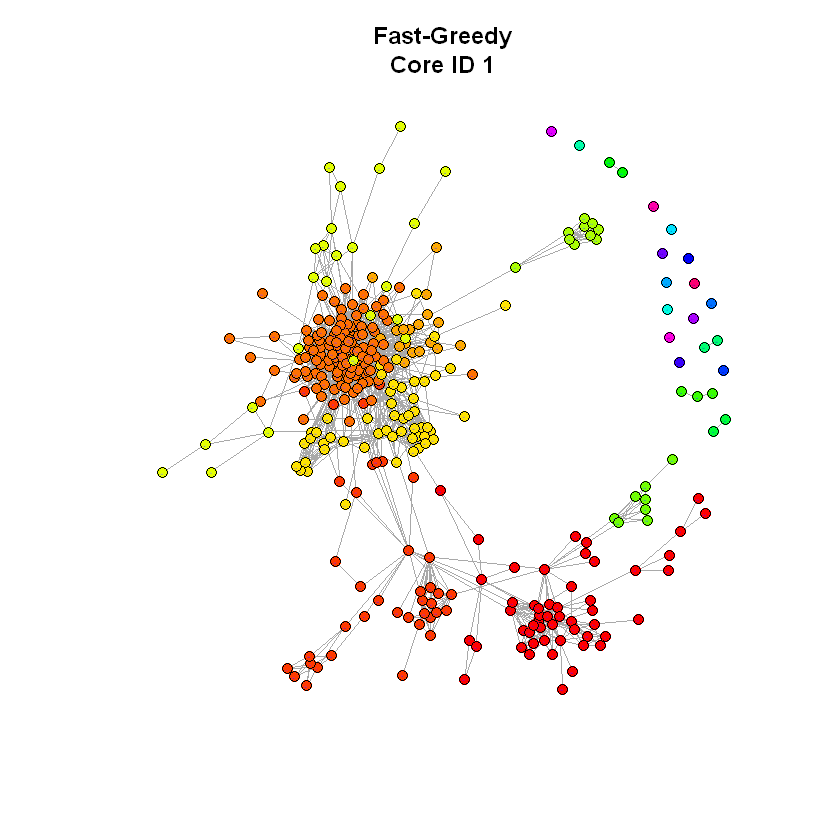

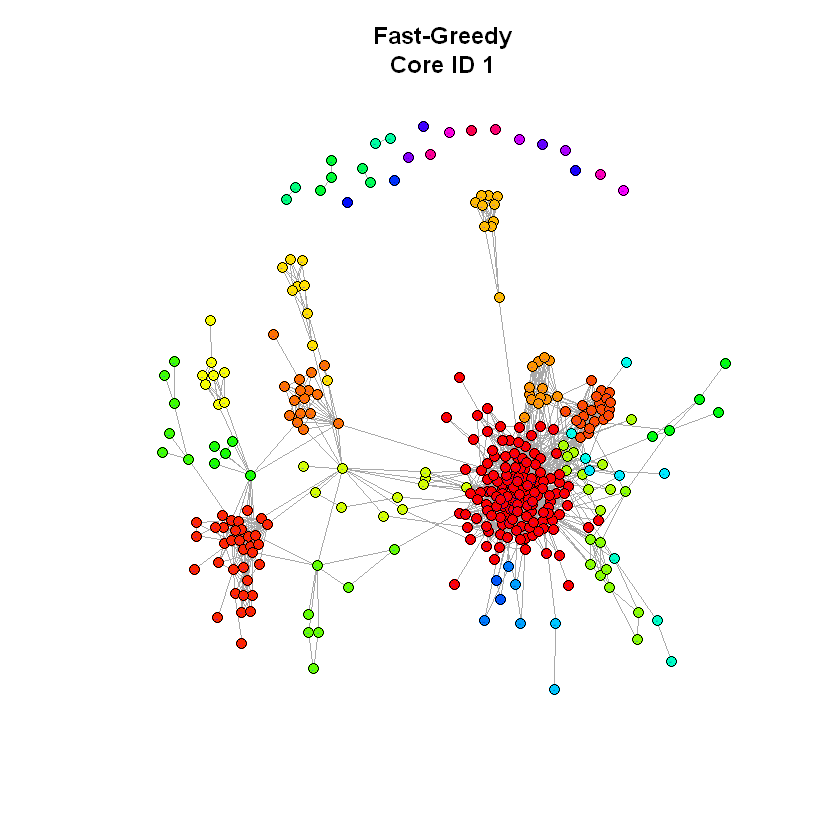

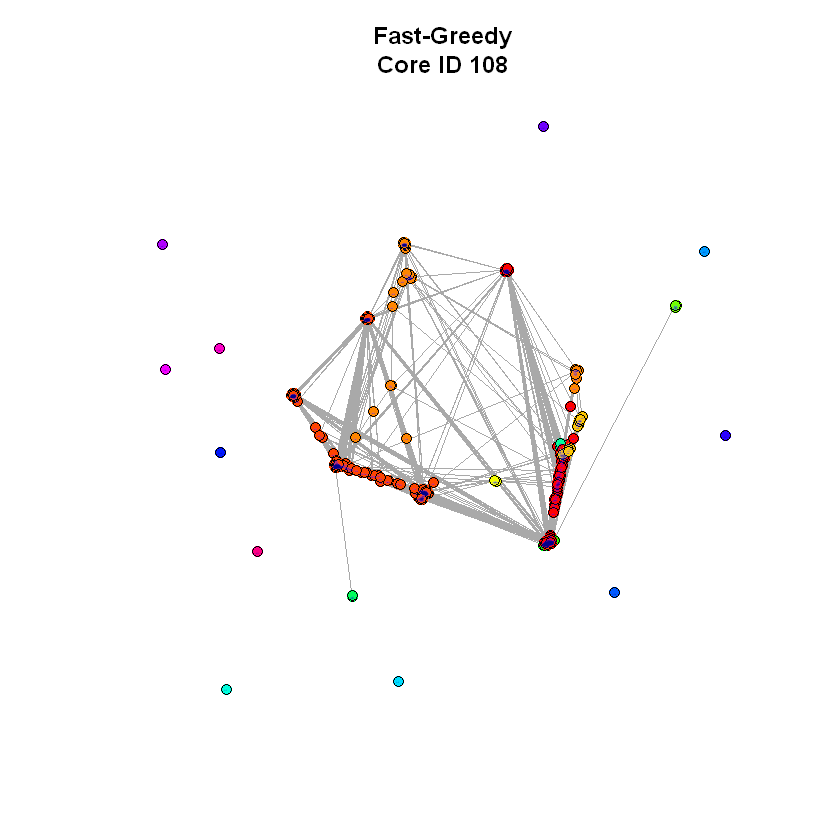

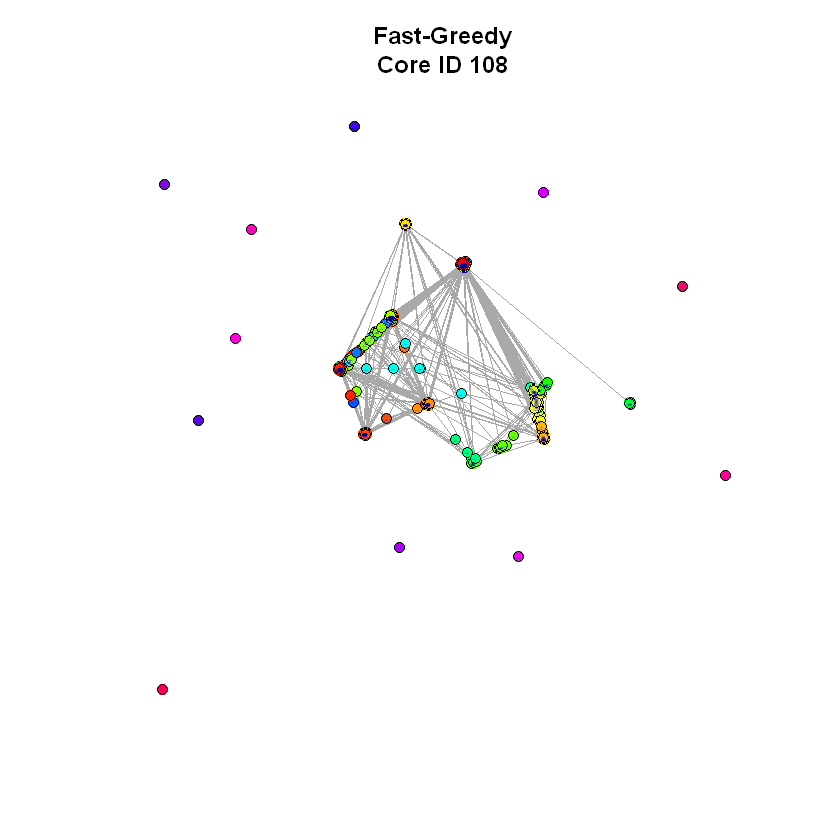

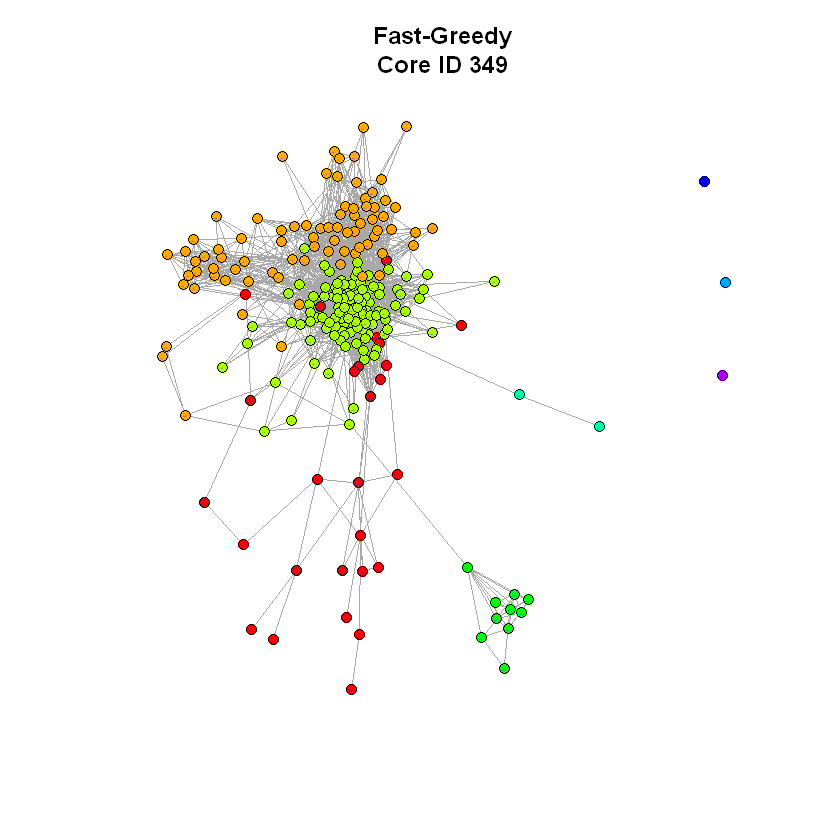

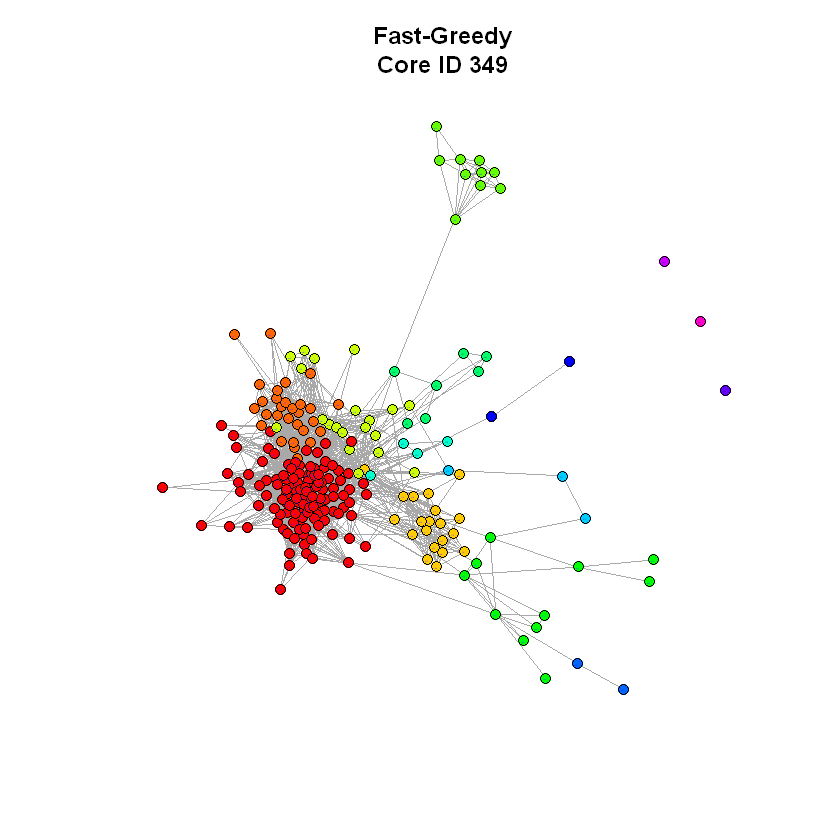

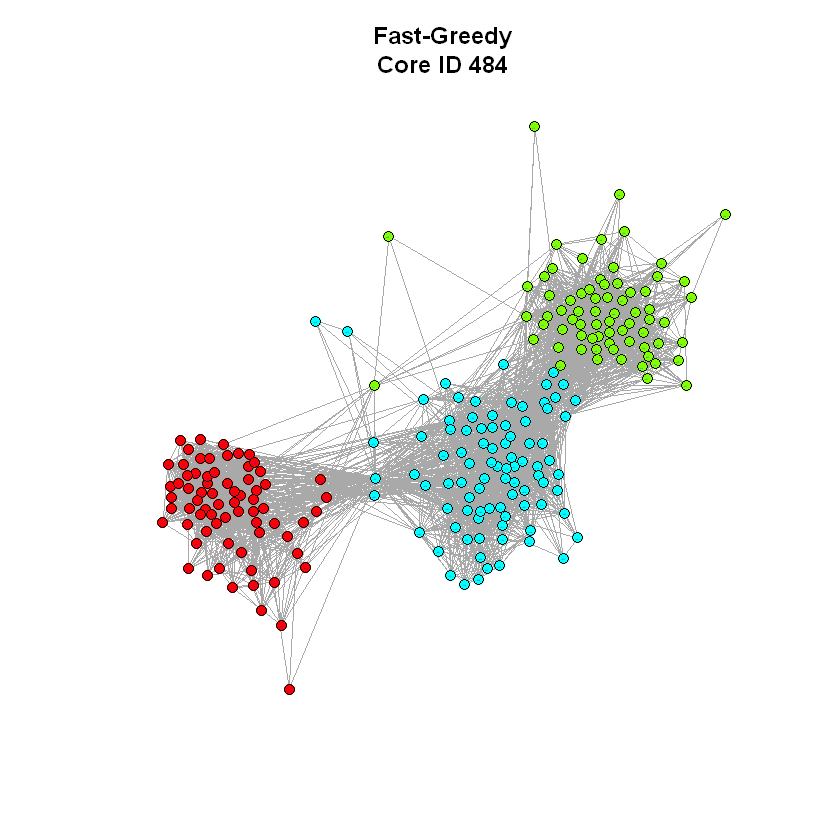

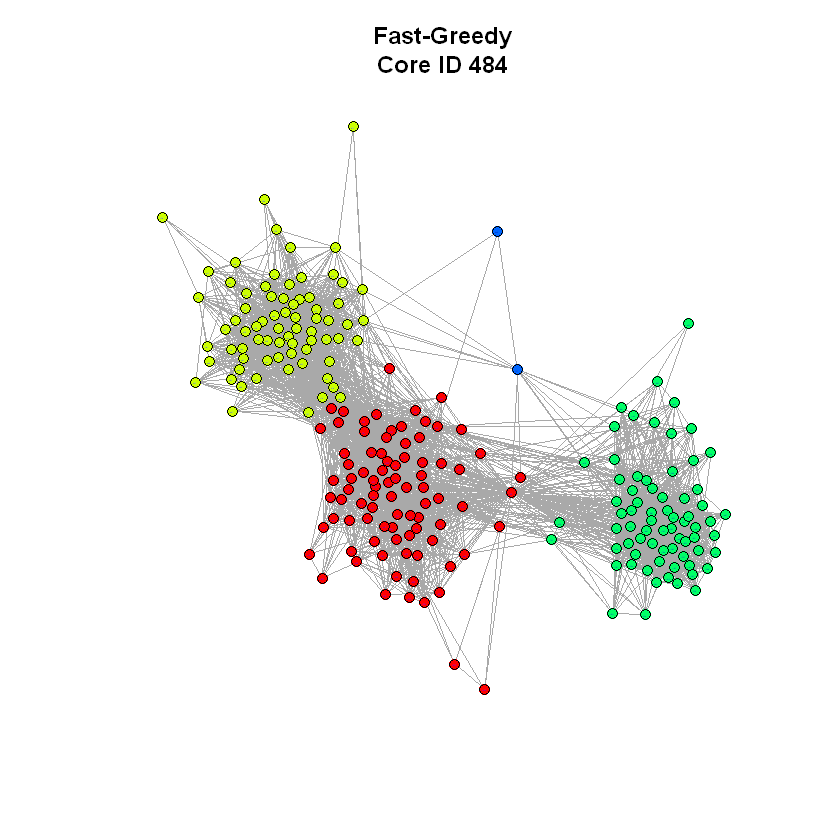

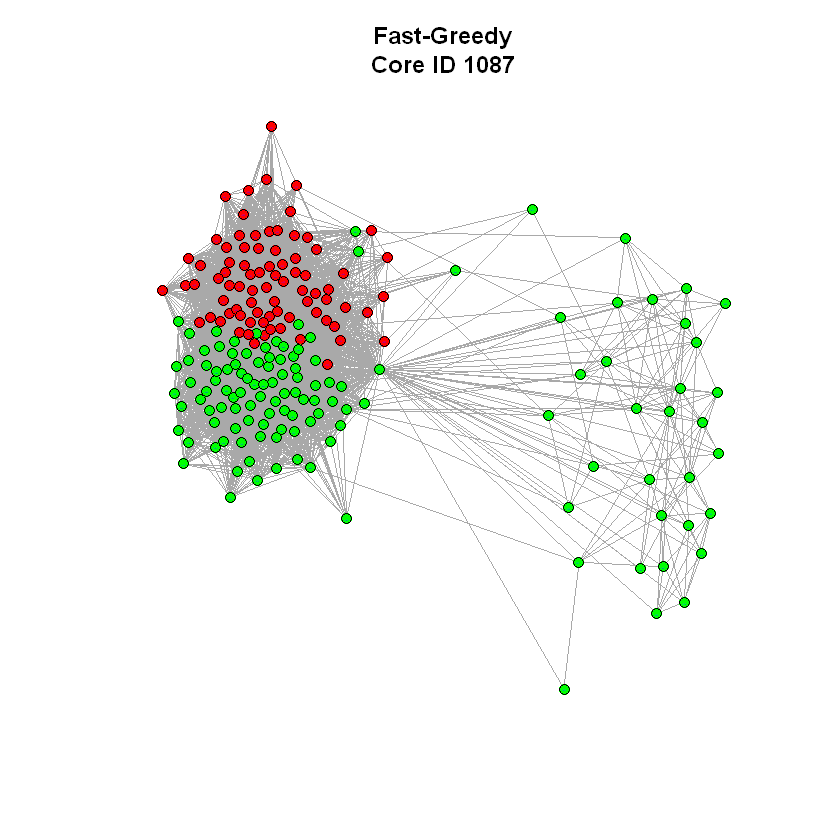

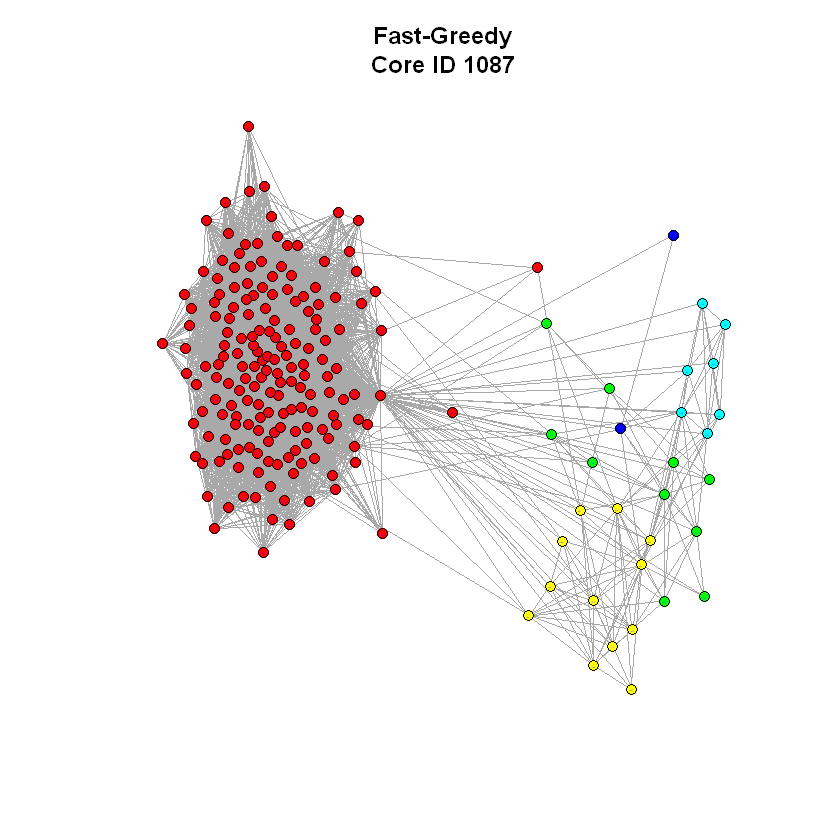

In [219]:
# just a redo of 1.3.2 to see if this is faster. 

core_ids <- c(1,108,349,484,1087)
p_graphs <- lapply(core_ids, create_personalized_network, g, F)

fg_wocore <- lapply(p_graphs, cluster_fast_greedy)
#eb_wocore <- lapply(p_graphs, cluster_edge_betweenness) # turns out edge_betweenness takes forever. 
im_wocore <- lapply(p_graphs, cluster_infomap)

fg_wocore.mods <- lapply(fg_wocore, function(x) max(x$mod))
#eb_wocore.mods <- lapply(eb_wocore, function(x) max(x$mod))
im_wocore.mods <- lapply(im_wocore, function(x) max(x$mod))
                         
for ( i in 1:length(core_ids) ) {
    g1 <- p_graphs[[i]]
    
    colors = rainbow(size(groups(fg_wocore[[i]]))+1)
    nodes_colors = colors[1:(length(colors)-1)]
    V(g1)$color = nodes_colors[membership(fg_wocore[[i]])]
    plot(g1,vertex.label=V(g1)$vid, vertex.size=4,vertex.label.cex=0.1,main=paste("Fast-Greedy","\n", "Core ID ",core_ids[i],"Omitted",sep=""))
    
#     colors = rainbow(size(groups(eb_wocore[[i]]))+1)
#     nodes_colors = colors[1:(length(colors)-1)]
#     V(g1)$color = nodes_colors[membership(eb_wocore[[i]])]
#     plot(g1,vertex.label=V(g1)$vid, vertex.size=4,vertex.label.cex=0.1,main=paste("Edge-Betweenness","\n", "Core ID ",core_ids[i],"Omitted",sep=""))
    
    colors = rainbow(size(groups(im_wocore[[i]]))+1)
    nodes_colors = colors[1:(length(colors)-1)]
    V(g1)$color = nodes_colors[membership(im_wocore[[i]])]
    plot(g1,vertex.label=V(g1)$vid, vertex.size=4,vertex.label.cex=0.1,main=paste("Infomap","\n", "Core ID ",core_ids[i],"Omitted",sep=""))
}

1. Because of how these graphs are constructed, the number of mutual friends that a node has is the degree of that node in the personalized network without the core node. Since each of the nodes in this network is a friend of the core node, the number of connections in this graph is equal to the embeddedness. 

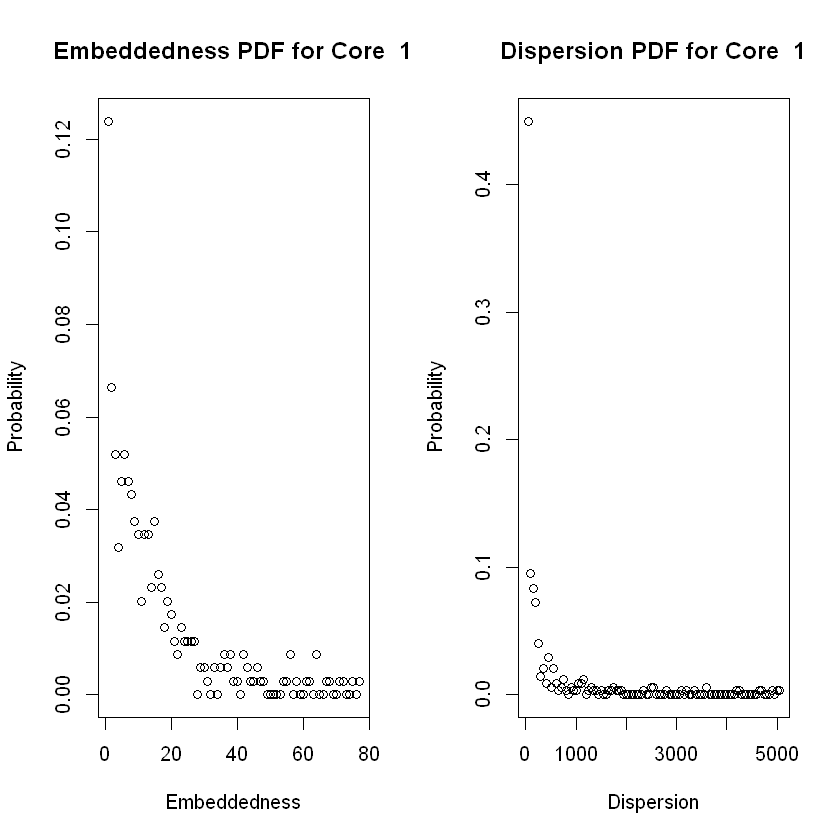

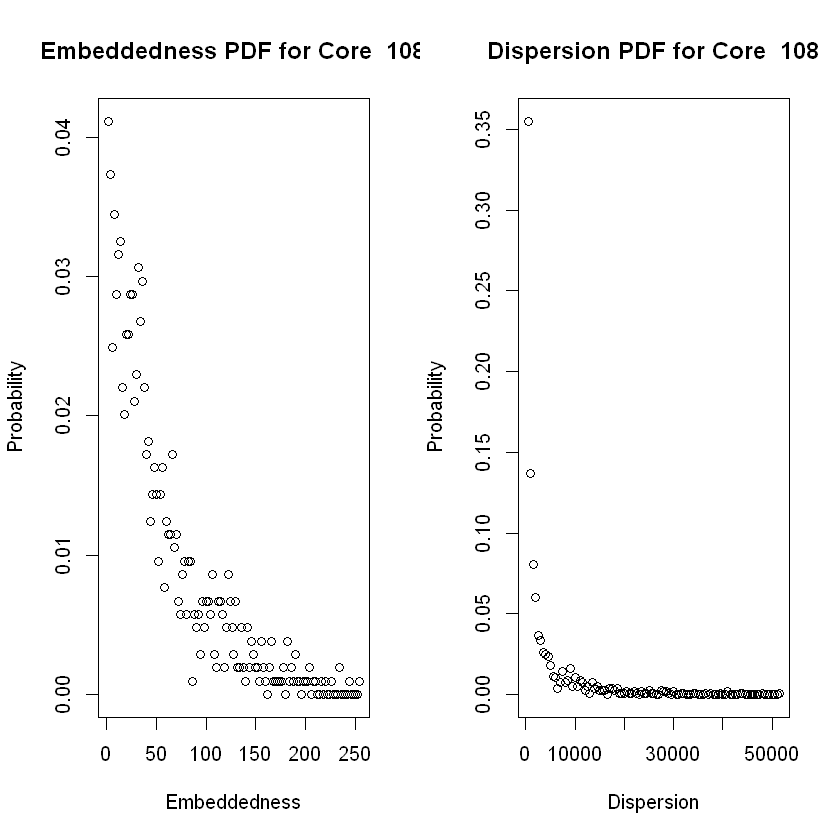

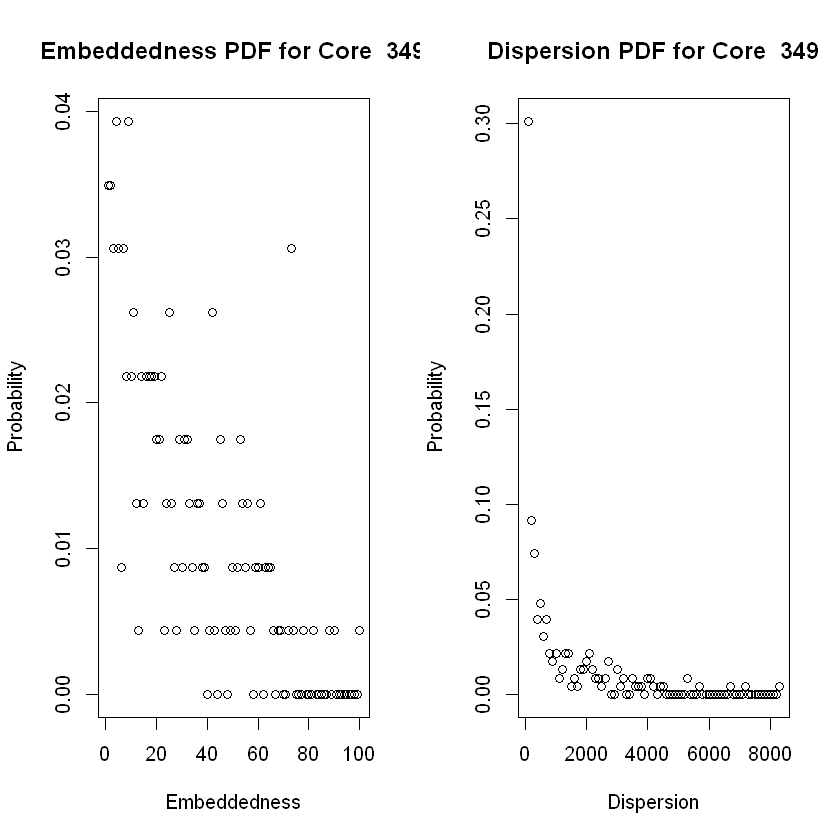

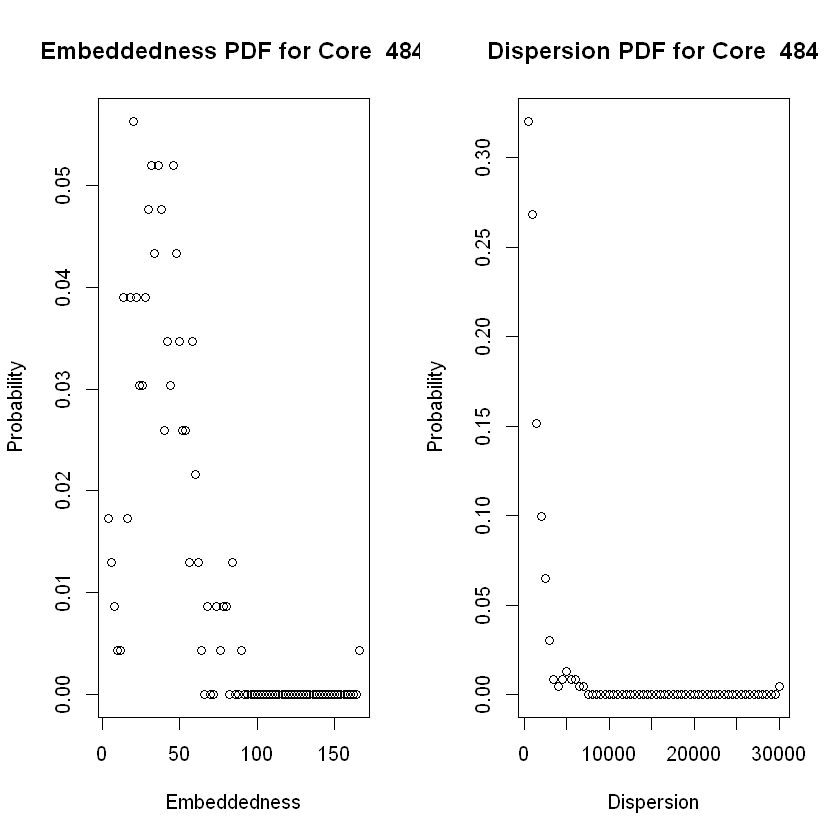

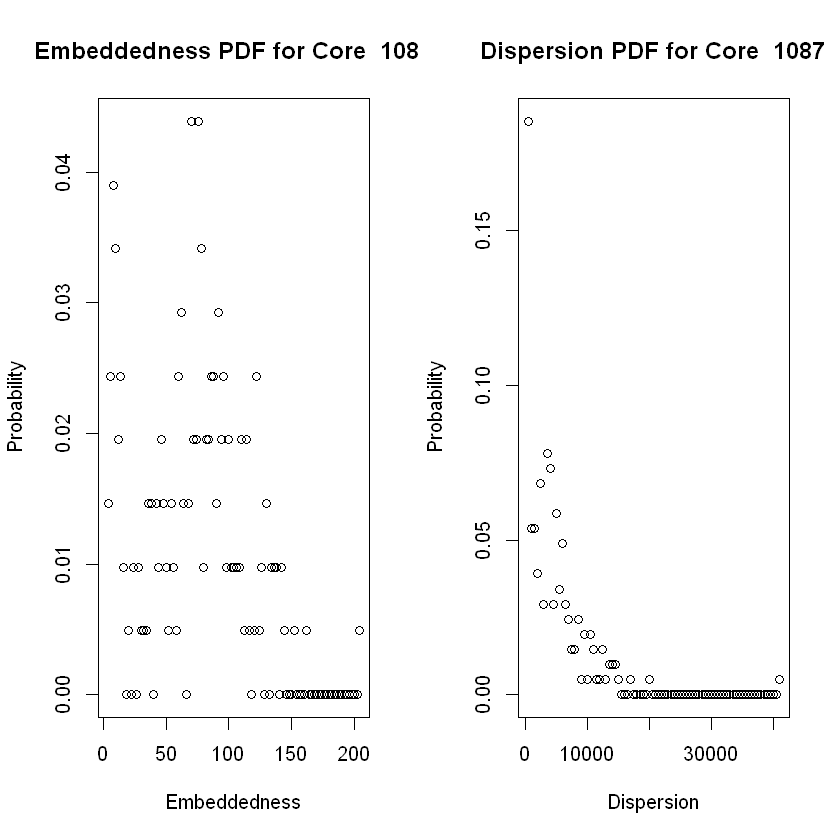

In [263]:
core_ids <- c(1,108,349,484,1087)

embeds <- lapply(core_ids, get_embeddedness, g, T)
disper <- lapply(core_ids, get_dispersion, g, T)

#par(mfrow=c(5,2)) #TODO: figure out proper formatting and stuff.

for( i in 1:length(core_ids)) {
    par(mfrow=c(1,2))
    plot(embeds[[i]]$breaks[2:length(embeds[[i]]$breaks)], embeds[[i]]$counts, main=paste("Embeddedness PDF for Core ", core_ids[i]), xlab='Embeddedness', ylab='Probability')
    plot(disper[[i]]$breaks[2:length(disper[[i]]$breaks)], disper[[i]]$counts, main=paste("Dispersion PDF for Core ", core_ids[i]), xlab='Dispersion', ylab='Probability')
}

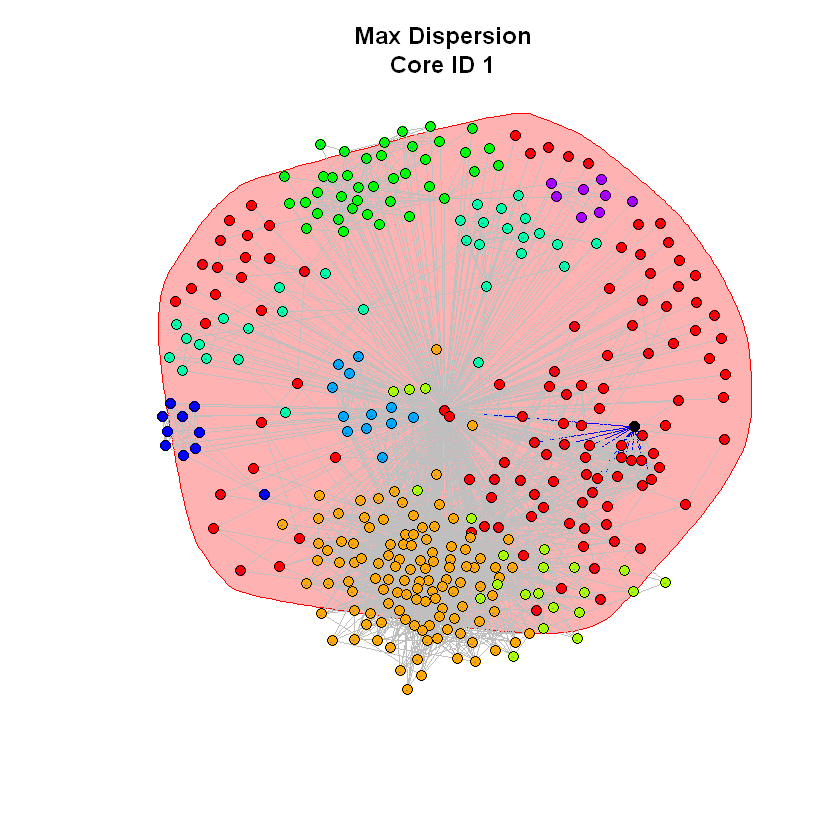

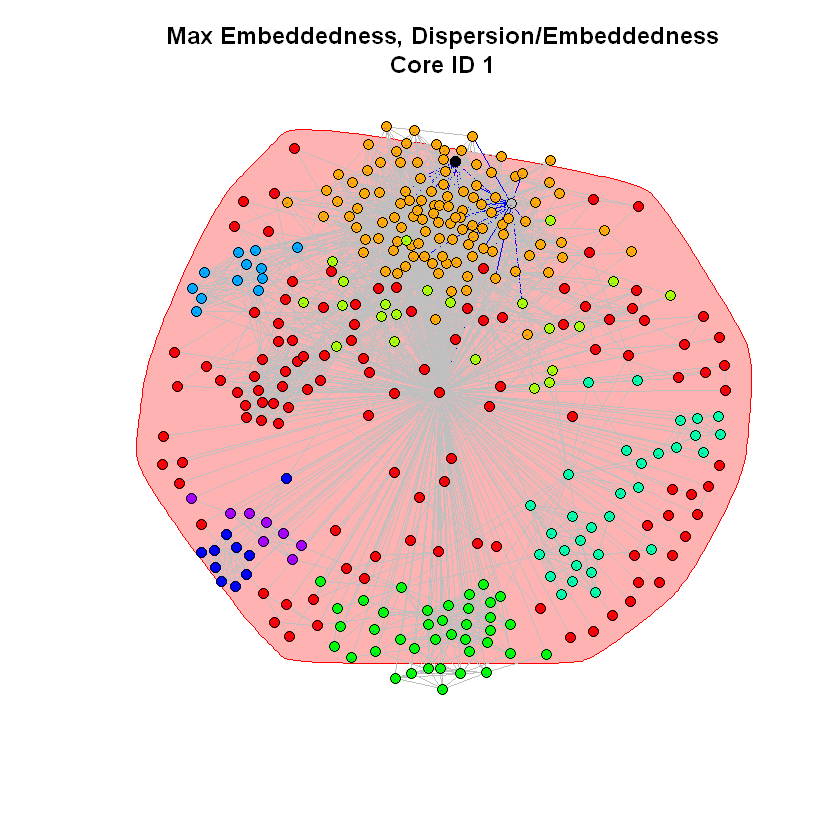

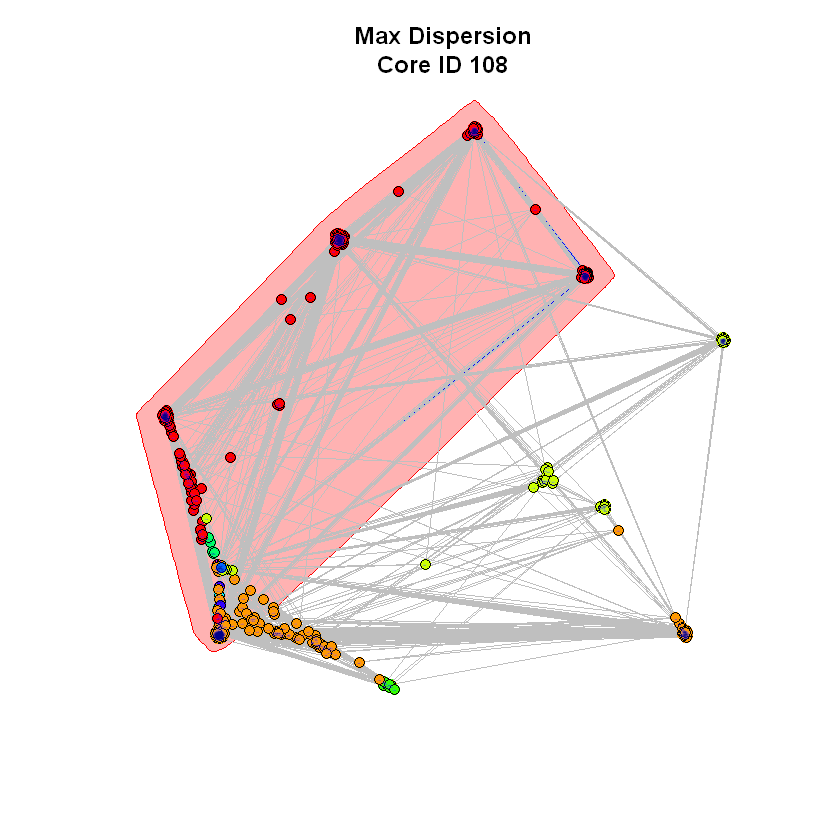

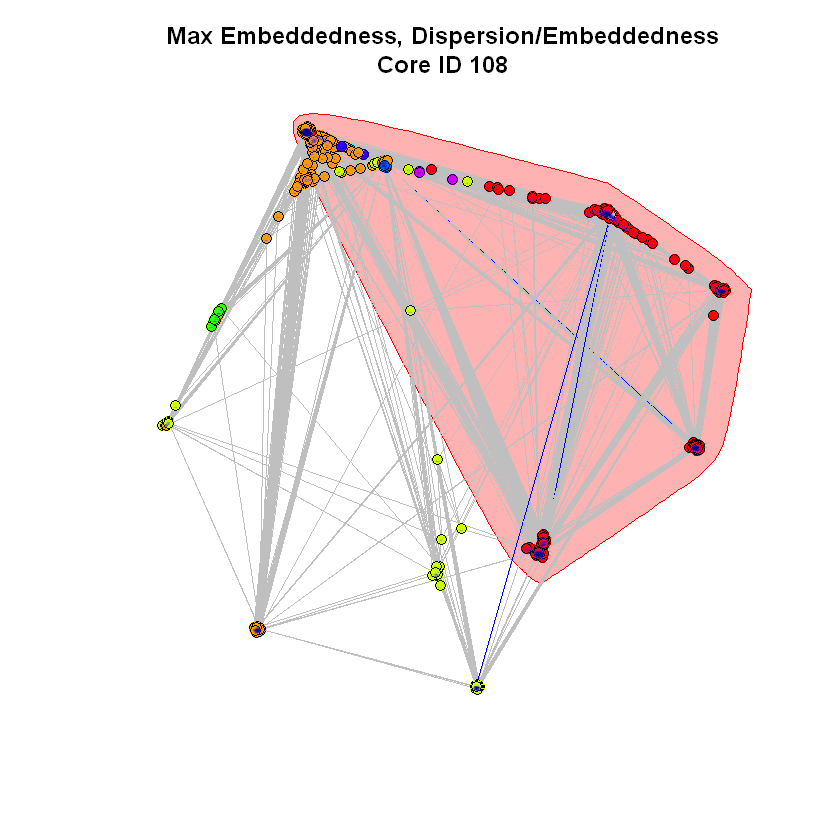

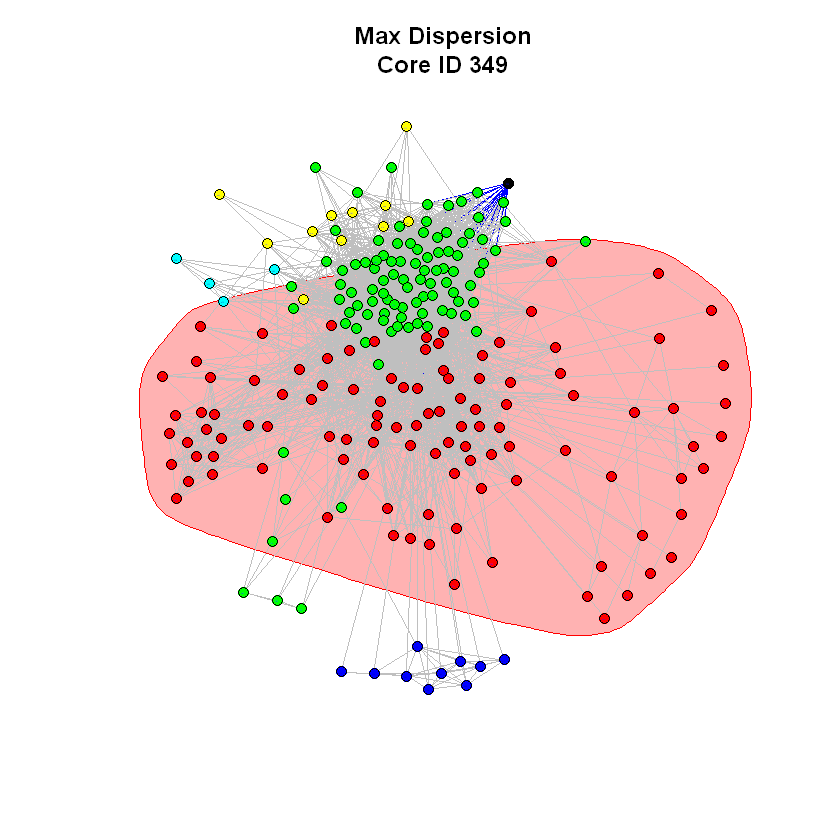

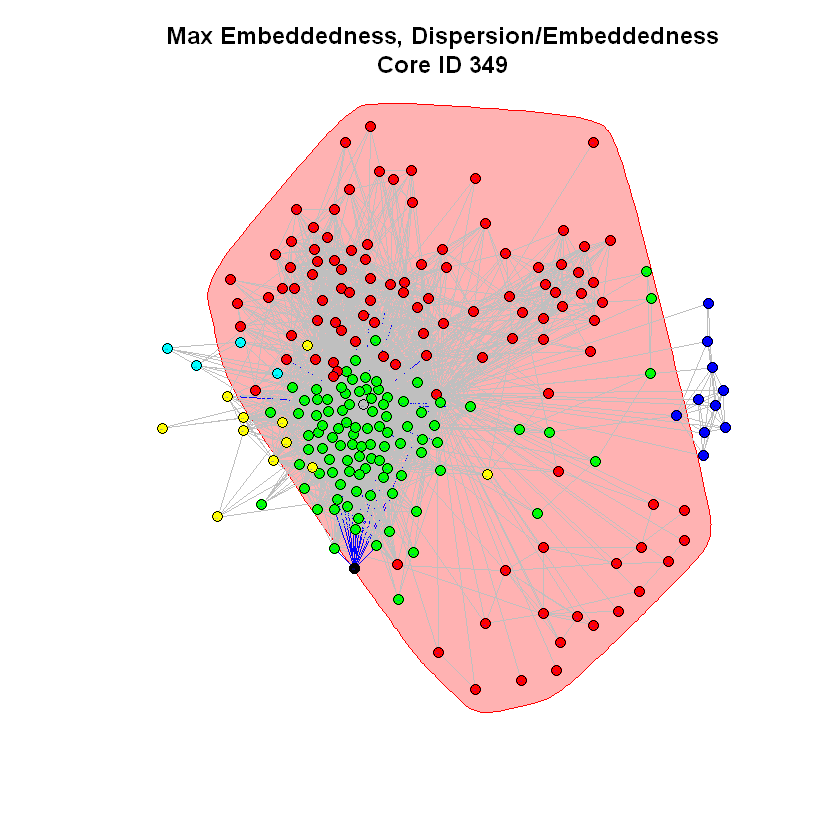

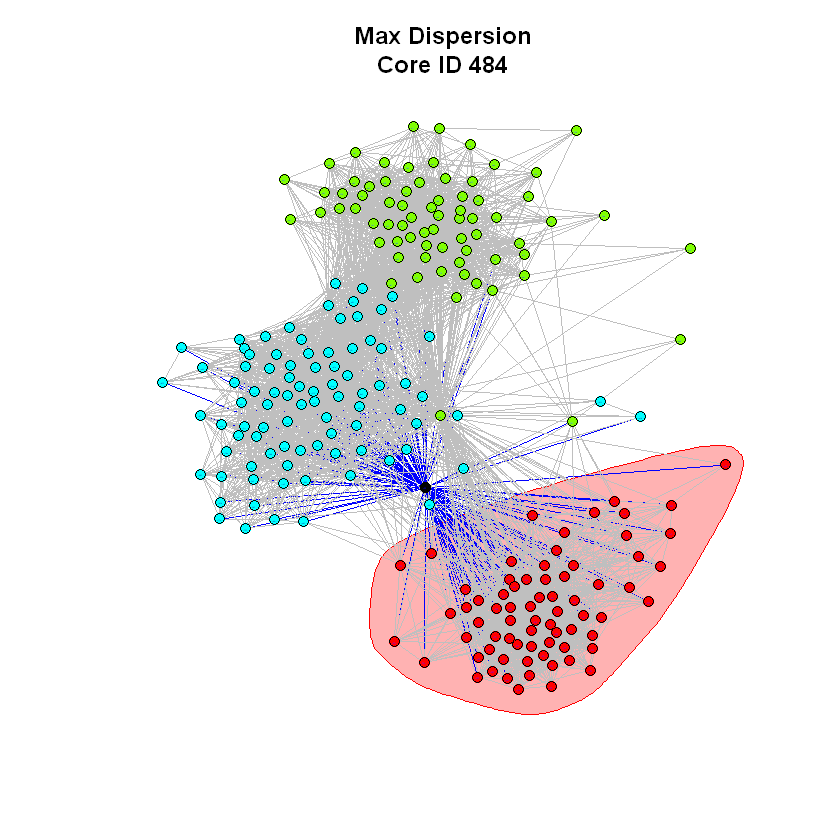

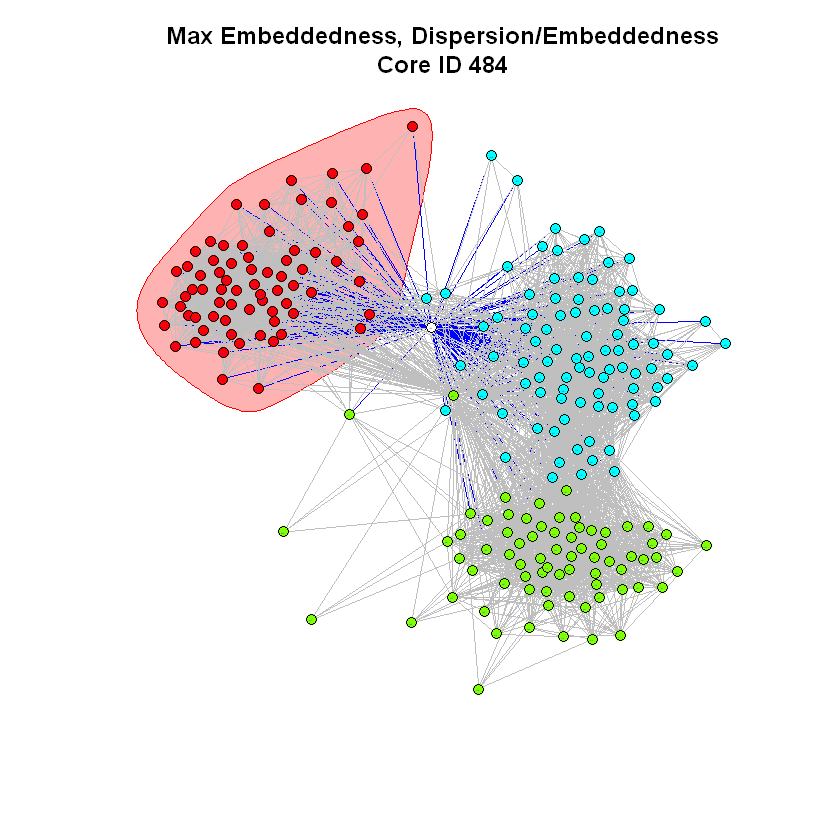

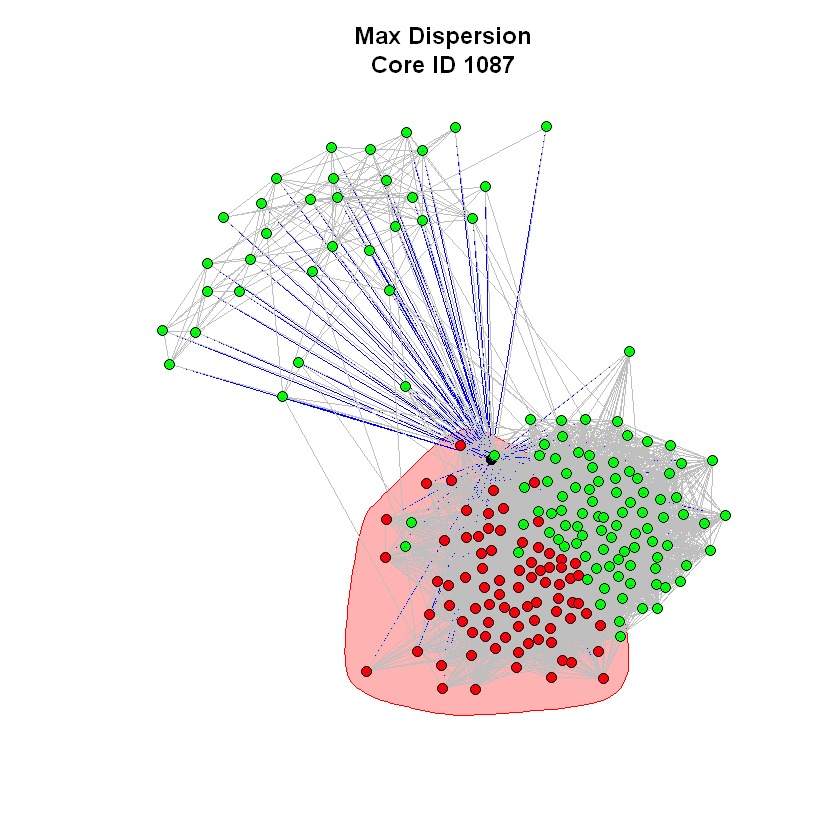

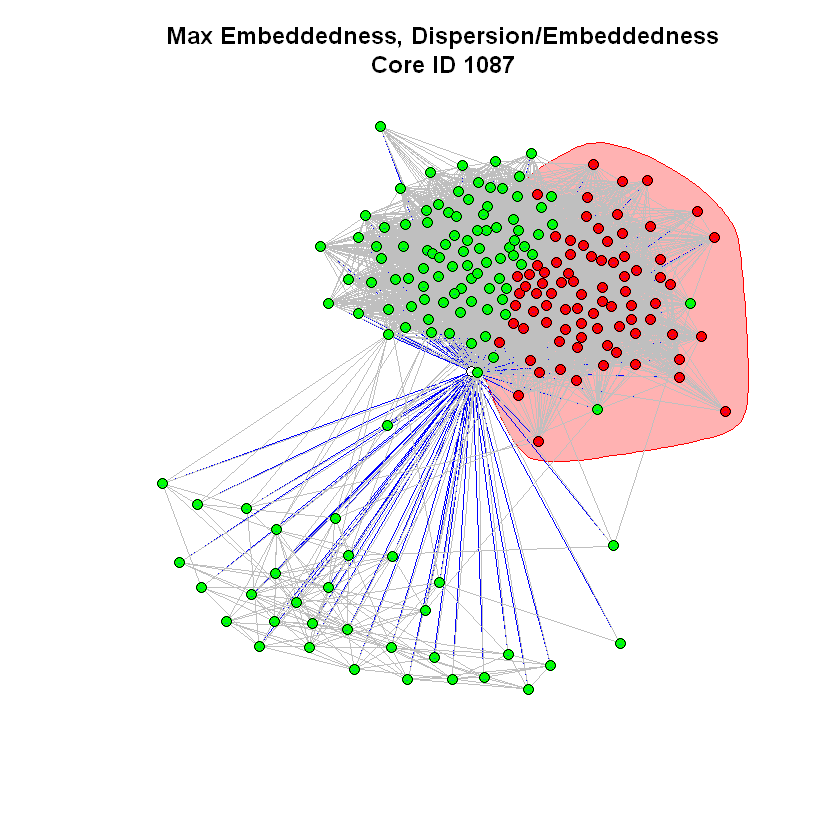

In [433]:
embed_vals <- lapply(core_ids, get_embeddedness, g, F)
disper_vals <- lapply(core_ids, get_dispersion, g, F)
ratio_vals <- list(length(embed_vals))
for ( i in 1:length(embed_vals)) {
    ratio_vals[[i]] = disper_vals[[i]] / embed_vals[[i]]
}

for (i in 1:length(core_ids)) {
    g1 <- p_graphs[[i]]
    d <- disper_vals[[i]]
    colors = rainbow(size(groups(fg_wcore[[i]]))+1)
    nodes_colors = colors[1:(length(colors)-1)]
    V(g1)$color = nodes_colors[membership(fg_wcore[[i]])]
    n<-sort(d,decreasing=TRUE, index.return=TRUE)

    #E(g1)$color = ;
    index_max <- n$ix[1]
    V(g1)$color[index_max] <- "black"

    size(groups(fg_wcore[[i]]))
    group <- groups(fg_wcore[[i]])[1]
    for (k in 1:size(groups(fg_wcore[[i]]))) {
        if ( index_max %in% groups(fg_wcore[[i]])[k] )
            group <- groups(fg_wcore[[i]])[k]
    }

    E(g1)$color <- "gray75"
    E(g1) [from(index_max)]$color <- "blue"
    plot(g1,vertex.label=V(g1)$vid, mark.groups=group, vertex.size=4,vertex.label.cex=0.1, main=paste("Max Dispersion","\n", "Core ID ",core_ids[i],sep=""))
    
    g1 <- p_graphs[[i]]
    e <- embed_vals[[i]]
    r <- ratio_vals[[i]]
    colors = rainbow(size(groups(fg_wcore[[i]]))+1)
    nodes_colors = colors[1:(length(colors)-1)]
    V(g1)$color = nodes_colors[membership(fg_wcore[[i]])]
    
    n<-sort(e,decreasing=TRUE, index.return=TRUE)
    index_max <- n$ix[1]
    
    r <- r[!(is.infinite(r)|is.nan(r))]
    n2<-sort(r,decreasing=TRUE, index.return=TRUE)
    index_max2 <- n2$ix[1]
    V(g1)$color[index_max] <- "black"
    if ( index_max == index_max2 )
        V(g1)$color[index_max] <- "white"
    else
        V(g1)$color[index_max2] <- "gray75"

    size(groups(fg_wcore[[i]]))
    group <- groups(fg_wcore[[i]])[1]
    for (k in 1:size(groups(fg_wcore[[i]]))) {
        if ( index_max %in% groups(fg_wcore[[i]])[k] )
            group <- groups(fg_wcore[[i]])[k]
    }

    E(g1)$color <- "gray75"
    E(g1) [from(index_max)]$color <- "blue"
    E(g1) [from(index_max2)]$color <- "blue"
    plot(g1,vertex.label=V(g1)$vid, mark.groups=group, vertex.size=4,vertex.label.cex=0.1, main=paste("Max Embeddedness, Dispersion/Embeddedness","\n", "Core ID ",core_ids[i],sep=""))
}

In [374]:
common.neighbors = function (g, i, j, measure=T){
    Si <- neighbors(g, i)
    Sj <- neighbors(g, j)
    
    common <- intersect(Si, Sj)
    if ( measure )
        return(length(common))
    return(common)
}

In [354]:
jaccard = function(g, i, j) {
    Si <- neighbors(g, i)
    Sj <- neighbors(g, j)
    
    common <- intersect(Si, Sj)
    combined <- union(Si, Sj)
    return(length(common)/length(combined))
}

In [343]:
adamic.adar = function(g, i, j) {
    Si <- neighbors(g, i)
    Sj <- neighbors(g, j)
    
    common <- intersect(Si, Sj)
    
    aa <- do.call('sum', lapply(common, function(node) 1/log(length(neighbors(g,node)))))
    return(aa)
}

In [358]:
jaccard.recommend = function(g, i, t) {
    m <- seq(1,vcount(g))
    included <- m %in% neighbors(g,i) | (m==i)
    m = m[!included]
    
    reccs <- numeric(length(m))
    for (j in 1:length(m)) {
        reccs[j] <- jaccard(g, i, m[j])
    }
    
    reccs <- sort(reccs,decreasing=TRUE, index.return=TRUE)
    return(reccs$ix[1:t])
}

In [363]:
common.neighbors.recommend = function(g, i, t) {
    m <- seq(1,vcount(g))
    included <- m %in% neighbors(g,i) | (m==i)
    m = m[!included]
    
    reccs <- numeric(length(m))
    for (j in 1:length(m)) {
        reccs[j] <- common.neighbors(g, i, m[j])
    }
    
    reccs <- sort(reccs,decreasing=TRUE, index.return=TRUE)
    return(reccs$ix[1:t])
}

In [364]:
adamic.adar.recommend = function(g, i, t) {
    m <- seq(1,vcount(g))
    included <- m %in% neighbors(g,i) | (m==i)
    m = m[!included]
    
    reccs <- numeric(length(m))
    for (j in 1:length(m)) {
        reccs[j] <- adamic.adar(g, i, m[j])
    }
    
    reccs <- sort(reccs,decreasing=TRUE, index.return=TRUE)
    return(reccs$ix[1:t])
}

In [413]:
common.neighbors.avacc = function(g, Nr) {
    n_iter <- 10
    
    sum <- 0
    for ( node in Nr ) {
        ed <- E(g)[from(node)]
        #g_temp <- g
        for ( i in 1:n_iter ) {
            rands <- sample(1:4, length(ed), replace=T)
            R_i <- neighbors(g, node)[rands==1] # this assumes neighbors and edges will always line up.
            if ( length(R_i) == 0 )
                next
            g_temp <- delete.edges(g, ed[rands==1])
            
            P_i <- common.neighbors.recommend(g, node, length(R_i))
            readded <- intersect(R_i, P_i)
            
            sum <- sum + length(readded)/length(R_i)
        }
    }
    return ( sum / length (Nr) / n_iter )
}

In [414]:
adamic.adar.avacc = function(g, Nr) {
    n_iter <- 10
    
    sum <- 0
    for ( node in Nr ) {
        ed <- E(g)[from(node)]
        #g_temp <- g
        for ( i in 1:n_iter ) {
            rands <- sample(1:4, length(ed), replace=T)
            R_i <- neighbors(g, node)[rands==1] # this assumes neighbors and edges will always line up.
            if ( length(R_i) == 0 )
                next
            g_temp <- delete.edges(g, ed[rands==1])
            
            P_i <- adamic.adar.recommend(g, node, length(R_i))
            readded <- intersect(R_i, P_i)
            
            sum <- sum + length(readded)/length(R_i)
        }
    }
    return ( sum / length (Nr) / n_iter )
}

In [415]:
jaccard.avacc = function(g, Nr) {
    n_iter <- 10
    
    sum <- 0
    for ( node in Nr ) {
        ed <- E(g)[from(node)]
        #g_temp <- g
        for ( i in 1:n_iter ) {
            rands <- sample(1:4, length(ed), replace=T)
            R_i <- neighbors(g, node)[rands==1] # this assumes neighbors and edges will always line up.
            if ( length(R_i) == 0 )
                next
            g_temp <- delete.edges(g, ed[rands==1])
            
            P_i <- jaccard.recommend(g, node, length(R_i))
            readded <- intersect(R_i, P_i)
            
            sum <- sum + length(readded)/length(R_i)
        }
    }
    return ( sum / length (Nr) / n_iter )
}

In [416]:
user <- 415
p_net <- create_personalized_network(user, g)
Nr <- V(p_net)[degree(p_net) == 24]
length(Nr)

cn <-common.neighbors.avacc(p_net, Nr)
ja <-jaccard.avacc(p_net, Nr)
aa <-adamic.adar.avacc(p_net, Nr)

[1] 11

In [417]:
cn

[1] 0.01377345

In [418]:
ja

[1] 0.03472255

In [419]:
aa

[1] 0.01935065

In [420]:
vcount(p_net)

[1] 160